## Importazione librerie

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import itertools
import Metriche_di_performance as mdp
import plotly.graph_objects as go
import config_API_Bybit as cab
from telegram import Bot
import asyncio
from threading import Thread

In [110]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# Sopprimi i RuntimeWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [111]:
dati = pd.read_csv('Bitcoin (€) da yfinance dal 17-09-2014 al 24-04-2024.csv')
dati = dati[['Date', 'Close']]
dati = dati.rename(columns = {'Date':'Timestamp', 'Close': 'Price'})
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
dati['Timestamp'] = dati['Timestamp'].dt.strftime('%Y-%m-%d')
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'], format='%Y-%m-%d')
dati

,Timestamp,Price
0,2014-09-17,355.957367
1,2014-09-18,328.539368
2,2014-09-19,307.761139
3,2014-09-20,318.758972
4,2014-09-21,310.632446
...,...,...
3503,2024-04-20,59876.710938
3504,2024-04-21,60956.074219
3505,2024-04-22,60919.242188
3506,2024-04-23,62729.296875


In [112]:
data_inizio = '2021-01-09'
data_fine = '2023-12-03'
indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
dati

,Timestamp,Price
0,2021-01-09,32928.058594
1,2021-01-10,31472.685547
2,2021-01-11,29247.208984
3,2021-01-12,27786.228516
4,2021-01-13,30682.929688
...,...,...
1054,2023-11-29,34379.074219
1055,2023-11-30,34499.992188
1056,2023-12-01,34625.015625
1057,2023-12-02,35518.437500


In [113]:
# def calcola_rendimento_portafoglio_ideale(colonna_prezzi, capitale_iniziale, bitcoin_iniziali, min_acquisto=0, min_vendita=0, perc_commissione_acquisto=0, perc_commissione_vendita=0):
#     capitale = capitale_iniziale
#     bitcoin = bitcoin_iniziali
#     comprato = False

#     # Iterazione sugli indici del dataframe
#     for i in range(len(colonna_prezzi) - 1):
#         prezzo_corrente = colonna_prezzi.iloc[i]
#         prezzo_successivo = colonna_prezzi.iloc[i + 1]

#         # Compra al minimo
#         if prezzo_corrente < prezzo_successivo and not comprato and capitale >= min_acquisto:
#                 spesa = capitale
#                 bitcoin_acquistati = (capitale * (1 - perc_commissione_acquisto)) / prezzo_corrente
#                 bitcoin += bitcoin_acquistati
#                 capitale = 0
#                 comprato = True

#         # Vende al massimo
#         elif prezzo_corrente > prezzo_successivo and comprato and bitcoin * prezzo_corrente >= min_vendita or (comprato and bitcoin * prezzo_corrente >= min_vendita and spesa / (1 - perc_commissione_vendita) > bitcoin * prezzo_corrente):
#                 capitale += bitcoin * prezzo_corrente * (1 - perc_commissione_vendita)
#                 bitcoin = 0
#                 comprato = False

#     # Vende i bitcoin rimasti all'ultimo prezzo
#     if comprato and bitcoin * colonna_prezzi.iloc[-1] >= min_vendita:
#             capitale += bitcoin * colonna_prezzi.iloc[-1] * (1 - perc_commissione_vendita)
#             bitcoin = 0

#     # Calcolo rendimento
#     valore_iniziale = capitale_iniziale + bitcoin_iniziali * colonna_prezzi.iloc[0]
#     valore_finale = capitale + bitcoin * colonna_prezzi.iloc[-1]

#     rendimento = valore_finale / valore_iniziale

#     return [rendimento, valore_finale]

In [114]:
def calcola_rendimento_portafoglio_ideale(colonna_prezzi, capitale_iniziale, bitcoin_iniziali, min_acquisto=0, min_vendita=0, perc_commissione_acquisto=0, perc_commissione_vendita=0):
    n = len(colonna_prezzi)
    
    # Tabella per memorizzare i massimi rendimenti
    dp = [[0] * 2 for _ in range(n)]  # dp[i][0]: massimo rendimento senza bitcoin, dp[i][1]: massimo rendimento con bitcoin

    # Stato iniziale
    dp[0][0] = capitale_iniziale  # Liquidità posseduta
    dp[0][1] = bitcoin_iniziali # Quantità bitcoin posseduti

    for i in range(1, n):
        prezzo_corrente = colonna_prezzi.iloc[i]

        # Caso 1: non ho bitcoin (capitale in liquidità)
        dp[i][0] = dp[i - 1][0]  # Mantengo il capitale
        if dp[i - 1][1] * prezzo_corrente >= min_vendita:  # Posso vendere bitcoin
            capitale_dopo_vendita = dp[i - 1][1] * prezzo_corrente * (1 - perc_commissione_vendita)
            dp[i][0] = max(dp[i][0], capitale_dopo_vendita)  # Massimo rendimento tra mantenere e vendere

        # Caso 2: ho bitcoin
        dp[i][1] = dp[i - 1][1]  # Mantengo i bitcoin
        if dp[i - 1][0] >= min_acquisto:  # Posso comprare bitcoin
            bitcoin_acquistati = (dp[i - 1][0] * (1 - perc_commissione_acquisto)) / prezzo_corrente
            dp[i][1] = max(dp[i][1], bitcoin_acquistati)  # Massimo rendimento tra mantenere e comprare

    # Rendimento finale: il massimo tra avere tutto in capitale o tutto in bitcoin all'ultimo prezzo
    valore_finale_capitale = dp[-1][0]
    valore_finale_bitcoin = dp[-1][1] * colonna_prezzi.iloc[-1] * (1 - perc_commissione_vendita)

    valore_iniziale = capitale_iniziale + bitcoin_iniziali * colonna_prezzi.iloc[0]
    valore_finale = max(valore_finale_capitale, valore_finale_bitcoin)

    rendimento = valore_finale / valore_iniziale

    return [rendimento, valore_finale]

In [115]:
def estrai_periodi_casuali(dati, N, L, start_date, end_date, random_state):
    # Filtra i dati tra start_date e end_date
    dati_filtrati = dati[(dati['Timestamp'] >= pd.to_datetime(start_date)) & 
                         (dati['Timestamp'] <= pd.to_datetime(end_date))]
    
    # Calcola il numero massimo di periodi non sovrapposti
    num_max_periodi = len(dati_filtrati) - L + 1
    
    # Controlla se è possibile estrarre N periodi diversi
    if num_max_periodi < N:
        raise ValueError(f"Non è possibile estrarre {N} periodi diversi di lunghezza {L} tra le date {start_date} e {end_date}.")
    
    # Inizializza una lista per i periodi estratti e un set per memorizzare gli estremi
    periodi_estratti = []
    estremi_estratti = set()
    
    # Inizializza il generatore di numeri casuali con il seed dato
    rng = np.random.RandomState(random_state)
    
    while len(periodi_estratti) < N:
        # Seleziona un indice casuale per l'inizio del periodo
        indice_inizio = rng.randint(0, len(dati_filtrati) - L + 1)
        
        # Determina gli estremi del periodo
        estremo_inizio = dati_filtrati.iloc[indice_inizio]['Timestamp']
        estremo_fine = dati_filtrati.iloc[indice_inizio + L - 1]['Timestamp']
        
        # Controlla se gli estremi sono già stati utilizzati
        if (estremo_inizio, estremo_fine) not in estremi_estratti:
            # Aggiungi gli estremi al set
            estremi_estratti.add((estremo_inizio, estremo_fine))
            
            # Estrai il periodo e aggiungilo alla lista dei periodi estratti
            periodo = dati_filtrati.iloc[indice_inizio:indice_inizio + L]

            periodo = periodo.reset_index(drop=True)

            periodi_estratti.append(periodo)
    
    return periodi_estratti

In [116]:
# start_date = dati['Timestamp'].iloc[0]
# end_date = dati['Timestamp'].iloc[-1]
# N = 100 # Numero di periodi da estrarre
# L = 60 # Lunghezza di ogni periodo in giorni
# random_state = 8

In [117]:
# periodi_casuali_esistenti = estrai_periodi_casuali(dati, N, L, start_date, end_date, random_state)
# print('Fattore di ritorno medio dei prezzi estratti:', np.mean([df['Price'].iloc[-1] / df['Price'].iloc[0] for df in periodi_casuali_esistenti]))

# ideal_returns = [calcola_rendimento_portafoglio_ideale(df['Price'], 1000, 0, 5, 5, 0.001, 0.001)[0] for df in periodi_casuali_esistenti]

# print('Media dei fattori di rendimento massimi ottenibili:', np.mean(ideal_returns))

# perc_suff = np.mean([1/calcola_rendimento_portafoglio_ideale(df['Price'], 1000, 0, 5, 5, 0.001, 0.001)[0] for df in periodi_casuali_esistenti])

# print(f'Punteggio percentuale considerato "sufficiente": {round(perc_suff*100,2)}%')

In [118]:
# datasets = [periodi_casuali_esistenti[i]['Price'].values for i in range(len(periodi_casuali_esistenti))]

# lunghezza_dataset = len(periodi_casuali_esistenti[0])

# # Converte i dataset generati in DataFrame
# generated_dfs = [pd.DataFrame({'Timestamp': dati['Timestamp'].iloc[:lunghezza_dataset], 'Price': prices}) for prices in datasets] # Fingo che le date siano tutte iniziate con data_inizio

# # Plotting
# plt.figure(figsize=(14, 7))

# # Plot del dataset originale
# plt.plot(dati['Timestamp'].iloc[:lunghezza_dataset], dati['Price'].iloc[:lunghezza_dataset].values, label='Original', linewidth=3)

# # Plot dei dataset generati
# for i, df in enumerate(generated_dfs):
#     plt.plot(df['Timestamp'], df['Price'], label=f'Generated Dataset {i+1}', alpha=0.7)

# plt.title('Generated Bitcoin Price Datasets')
# plt.xlabel('Time')
# plt.ylabel('Price')
# # plt.yscale('log')
# plt.grid()
# # plt.legend()
# plt.show()

In [119]:
# dati_da_usare = periodi_casuali_esistenti.copy()

In [120]:
# # Lista per contenere tutti i dataset trasformati
# dati_da_usare = []

# # Loop attraverso i file CSV numerati da -3 a 3
# for num in range(-3, 4):
#     # Costruisci il percorso del file
#     path = rf'7 cluster con 100 dataset sintetici\Cluster_{num}.csv'
    
#     # Leggi il CSV
#     df = pd.read_csv(path)
    
#     # Loop attraverso le colonne dei prezzi
#     for col in df.columns[1:]:  # Escludi la prima colonna 'Timestamp'
#         # Crea un nuovo dataframe con 'Timestamp' e la colonna corrente
#         temp_df = df[['Timestamp', col]].copy()
        
#         # Rinomina la colonna corrente in 'Price'
#         temp_df.rename(columns={col: 'Price'}, inplace=True)
        
#         # Aggiungi il dataset trasformato alla lista
#         dati_da_usare.append(temp_df)

In [121]:
# # Dataset con timeframe di 1 giorno

# dati_da_usare = []

# path = r'100_datasets_60_days_random_state_8_period_9_jan_2021_3_dic_2023.csv'
# df = pd.read_csv(path)
# for col in df.columns[1:]:  # Escludi la prima colonna 'Timestamp'
#         temp_df = df[['Timestamp', col]].copy()
#         temp_df['Timestamp'] = pd.to_datetime(temp_df['Timestamp'])
#         temp_df.rename(columns={col: 'Price'}, inplace=True)
#         dati_da_usare.append(temp_df)

# dati_da_usare[0]

In [122]:
# Dataset con timeframe di 1 minuto

dati_da_usare = []

path = r'100_datasets_1440_minutes_random_state_8_bybit_period_9_jan_2021_3_dic_2023.csv'
df = pd.read_csv(path)
for col in df.columns[1:]:  # Escludi la prima colonna 'Timestamp'
        temp_df = df[['Timestamp', col]].copy()
        temp_df['Timestamp'] = pd.to_datetime(temp_df['Timestamp'])
        temp_df.rename(columns={col: 'Price'}, inplace=True)
        dati_da_usare.append(temp_df)

dati_da_usare[0]

,Timestamp,Price
0,2021-01-09 00:00:00+00:00,49016.13
1,2021-01-09 00:01:00+00:00,49048.53
2,2021-01-09 00:02:00+00:00,49079.37
3,2021-01-09 00:03:00+00:00,49079.98
4,2021-01-09 00:04:00+00:00,48970.00
...,...,...
1435,2021-01-09 23:55:00+00:00,48997.47
1436,2021-01-09 23:56:00+00:00,48917.63
1437,2021-01-09 23:57:00+00:00,48963.67
1438,2021-01-09 23:58:00+00:00,48960.65


In [123]:
print('Fattore di ritorno medio dei prezzi estratti:', np.mean([df['Price'].iloc[-1] / df['Price'].iloc[0] for df in dati_da_usare]))

ideal_returns = [calcola_rendimento_portafoglio_ideale(df['Price'], 1000, 0, 5, 5, 0.001, 0.001)[0] for df in dati_da_usare]

print('Media dei fattori di rendimento massimi ottenibili:', np.mean(ideal_returns))

perc_suff = np.mean([1/calcola_rendimento_portafoglio_ideale(df['Price'], 1000, 0, 5, 5, 0.001, 0.001)[0] for df in dati_da_usare])

print(f'Punteggio percentuale considerato "sufficiente": {round(perc_suff*100,2)}%')

Fattore di ritorno medio dei prezzi estratti: 0.9950356149376063
Media dei fattori di rendimento massimi ottenibili: 1.1437462225879773
Punteggio percentuale considerato "sufficiente": 88.73%


In [124]:
calcola_rendimento_portafoglio_ideale(dati_da_usare[6]['Price'], 1000, 0, 5, 5, 0.001, 0.001)[0]

np.float64(1.5102127868435358)

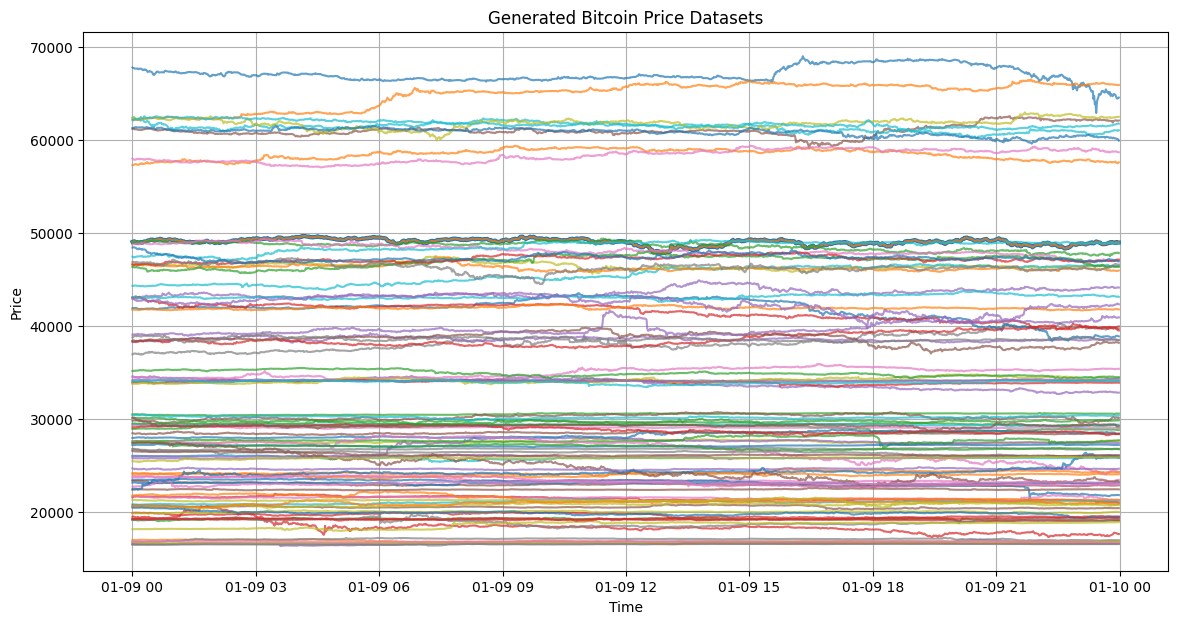

In [125]:
datasets = [dati_da_usare[i]['Price'].values for i in range(len(dati_da_usare))]

lunghezza_dataset = len(dati_da_usare[0])

# Converte i dataset generati in DataFrame
dfs = [pd.DataFrame({'Timestamp': dati_da_usare[0]['Timestamp'].iloc[:lunghezza_dataset], 'Price': prices}) for prices in datasets] # Fingo che le date siano tutte iniziate con data_inizio

# Plotting
plt.figure(figsize=(14, 7))

# Plot del dataset originale
plt.plot(dati_da_usare[0]['Timestamp'].iloc[:lunghezza_dataset], dati_da_usare[0]['Price'].iloc[:lunghezza_dataset].values, label='Original', linewidth=3)

# Plot dei dataset generati
for i, df in enumerate(dfs):
    plt.plot(df['Timestamp'], df['Price'], label=f'Generated Dataset {i+1}', alpha=0.7)

plt.title('Generated Bitcoin Price Datasets')
plt.xlabel('Time')
plt.ylabel('Price')
# plt.yscale('log')
plt.grid()
# plt.legend()
plt.show()

## Grid search

In [126]:
# Funzione per inviare un messaggio su Telegram
class TelegramNotifier:
    def __init__(self, token, chat_id):
        self.bot = Bot(token=token)
        self.chat_id = chat_id
        self.loop = asyncio.new_event_loop()
        self.thread = Thread(target=self._start_loop, daemon=True)
        self.thread.start()

    def _start_loop(self):
        asyncio.set_event_loop(self.loop)
        self.loop.run_forever()

    def invia_messaggio(self, messaggio):
        asyncio.run_coroutine_threadsafe(
            self.bot.send_message(chat_id=self.chat_id, text=messaggio),
            self.loop
        )

In [127]:
def grid_search_trading_strategy(
    dati_da_usare,
    strategia,
    param_combinations,
    nomi_parametri_variabili,
    parametri_fissi,
    ind_partenza,
    ind_fine,
    condizioni_salto,
    target='punteggio_rendimento_medio',
    use_telegram=False,
    calcola_metriche_performance=False,
    custom_target_function=None,  # Funzione personalizzata per il calcolo del target
    custom_target_description=None,
    taglia_ad_ultima_vendita=False
):
    """
    Esegue una grid search su una strategia di trading, trovando la migliore combinazione di parametri
    che massimizza un target specifico (rendimento_medio o punteggio_rendimento_medio).
    
    Args:
        dati_da_usare (list): Lista di DataFrame contenenti i dati di prezzo per i vari periodi.
        strategia (function): Strategia di trading da ottimizzare.
        param_combinations (list): Lista delle combinazioni di parametri da testare (ottenuta con itertools.product).
        parametri_fissi (dict): Dizionario di parametri fissi da passare alla strategia.
        ind_partenza (int): Indice di partenza per la grid search.
        ind_fine (int): Indice di fine per la grid search. Default è la lunghezza delle combinazioni di parametri.
        condizioni_salto (list): Lista di booleani che mi dicono se saltare o meno una combinazione perchè darebbe risultati uguali a combinazioni già viste
        target (str, optional): Target da massimizzare ('rendimento_medio', 'punteggio_rendimento_medio' o 'garanzia'). Default è 'punteggio_rendimento_medio'.
        telegram (bool, optional): Se True, invia via telegram i risultati della grid search. Default è False.
        calcola_metriche_performance (bool, optional): Se True, mostra anche le metriche di performance che ho definito in Metriche_di_performance.py. Default è False.
        custom_target_function (function, optional): Funzione personalizzata per calcolare il target. Default è None.
        custom_target_description (string, optional): Stringa che dice la funzione custom usata. Default è None.
        taglia_ad_ultimo_ciclo (bool, optional): Se True, ogni dataset viene usato inizialmente per intero, per poi essere tagliato al giorno dell'ultima vendita (incluso), e quindi i rendimenti ideali vengono calcolati sui dataset tagliati anzichè sui totali (se non ci sono state vendite, viene considerato il dataset totale). Default è False.
        
    Returns:
        pd.DataFrame: DataFrame ordinato contenente i risultati della grid search.
    """

    if use_telegram:
        telegram_notifier = TelegramNotifier(cab.token_telegram, cab.id_chat_mio_gruppo)

    # Se custom_target_function non è specificata, usa la funzione identità
    if custom_target_function is None:
        custom_target_function = lambda targets: targets[target]

    if custom_target_description is None:
        custom_target_description = target

    # if parametri_fissi is None:
    #     parametri_fissi = {}

    total_combinations = len(param_combinations)

    # if ind_fine is None:
    #     ind_fine = total_combinations

    # Inizializza variabili per tenere traccia delle coppie migliori e peggiori
    best_pair = {'score': -np.inf, 'total_return_factor': -np.inf, 'dataset': None, 'params': None, 'transactions': None}
    worst_pair = {'score': np.inf, 'total_return_factor': np.inf, 'dataset': None, 'params': None, 'transactions': None}

    best_value = -np.inf
    combinazione_max = None
    grid_search_results = []
    list_transactions = []

    saltate = 0
    calcolate = 0

    # Inizia la grid search
    for ind, params in enumerate(param_combinations):
        if ind_partenza <= ind + 1 <= ind_fine:
            parametri_e_valori = [nomi_parametri_variabili[j] + "=" + str(params[j]) for j in range(len(nomi_parametri_variabili))]

            # Verifica se saltare la combinazione
            if condizioni_salto[ind]:
                print(f'Salto la combinazione {ind+1}/{total_combinations} ({parametri_e_valori}) perchè sarebbe identica a una combinazione già vista...\n')
                saltate += 1
                continue

            print(f"Sto calcolando la combinazione {ind+1}/{total_combinations} ({parametri_e_valori}) ({calcolate} calcolate, {saltate} saltate)...")
            calcolate += 1
            
            # Lista per conservare i rendimenti per ogni dataset
            total_return_factors = []

            ideal_returns = []

            for i, df in enumerate(dati_da_usare):
                transactions = strategia(df, **{**dict(zip(nomi_parametri_variabili, params)), **parametri_fissi})
                if taglia_ad_ultima_vendita and not transactions[transactions['azione'] == 'Vendita'].empty:
                    indice_ultima_vendita = transactions[transactions['azione'] == 'Vendita']['timestamp'].idxmax()
                    transactions = transactions.iloc[:indice_ultima_vendita + 1]
                    ideal_return = calcola_rendimento_portafoglio_ideale(df['Price'].iloc[:indice_ultima_vendita + 1], *[parametri_fissi[chiave] for chiave in parametri_fissi.keys()])[0]
                else:
                    ideal_return = calcola_rendimento_portafoglio_ideale(df['Price'], *[parametri_fissi[chiave] for chiave in parametri_fissi.keys()])[0]
                ideal_returns.append(ideal_return)
                portfolio_values = transactions['valore_totale_portafoglio']
                total_return_factor = portfolio_values.iloc[-1] / (parametri_fissi['initial_cash'] + parametri_fissi['initial_bitcoin'] * df['Price'].iloc[0])
                total_return_factors.append(total_return_factor)

                if calcola_metriche_performance:
                    list_transactions.append([transactions['valore_totale_portafoglio'], transactions['prezzo'], transactions['bitcoin']])

                # Gestisci il best/worst se necessario (facoltativo)
                # Calcola il punteggio rendimento
                punteggio_rendimento = total_return_factor / ideal_return
                # Aggiorna la coppia migliore e peggiore
                if punteggio_rendimento > best_pair['score']:
                    best_pair = {'score': punteggio_rendimento, 'total_return_factor': total_return_factor, 'dataset': i, 'params': parametri_e_valori, 'transactions': transactions}
                if punteggio_rendimento < worst_pair['score']:
                    worst_pair = {'score': punteggio_rendimento, 'total_return_factor': total_return_factor, 'dataset': i, 'params': parametri_e_valori, 'transactions': transactions}

            punteggio_rendimento_medio = np.mean([trf / ir for trf, ir in zip(total_return_factors, ideal_returns)])
            rendimento_medio = np.mean(total_return_factors)
            garanzia = np.mean([trf > 1 for trf in total_return_factors])
            std_punteggi = np.std([trf / ir for trf, ir in zip(total_return_factors, ideal_returns)])

            # Dizionario per mappare i target e i valori associati
            target_map = {
                'punteggio_rendimento_medio': punteggio_rendimento_medio,
                'rendimento_medio': rendimento_medio,
                'garanzia': garanzia, # Aggiungere nuove variabili qui in futuro
            }

            # Calcola il valore del target usando la funzione personalizzata
            current_value = custom_target_function(target_map)
            
            # Salva i risultati
            grid_search_results.append({
                **dict(zip(nomi_parametri_variabili, params)),
                'rendimento_medio': rendimento_medio,
                'punteggio_rendimento_medio': punteggio_rendimento_medio,
                'garanzia': garanzia,
                'deviazione_standard_punteggi': std_punteggi,
                'custom_target': current_value,
            })

            print(f'Fattore Rendimento Medio: {rendimento_medio}')
            print(f'Punteggio rendimento medio: {punteggio_rendimento_medio}')
            print(f'Garanzia: {garanzia}')
            print(f'Deviazione standard dei punteggi di rendimento ottenuti sui vari dataset: {std_punteggi}')
            print(f'Custom Target Value: {current_value}')

            if calcola_metriche_performance:                
                # Calcolo delle metriche di performance per ogni dataset usando le funzioni della libreria 'mdp'
                media_max_drawdown = np.mean([mdp.max_drawdown(trans[0]) for trans in list_transactions])
                media_volatilita = np.mean([mdp.volatility(trans[0]) for trans in list_transactions])
                media_sharpe_ratio = np.mean([mdp.sharpe_ratio(trans[0]) for trans in list_transactions])
                media_sortino_ratio = np.mean([mdp.sortino_ratio(trans[0]) for trans in list_transactions])
                media_calmar_ratio = np.mean([mdp.calmar_ratio(trans[0]) for trans in list_transactions])
                media_profit_factor = np.mean([mdp.profit_factor(trans[1], trans[2]) for trans in list_transactions])
                media_pnl_per_trade = np.mean([np.mean(mdp.calcola_pnl(trans[1], trans[2])) for trans in list_transactions])

                # Stampa delle metriche calcolate
                print(f'Media max drawdown: {media_max_drawdown:.2f}%')
                print(f'Media volatilità: {media_volatilita:.2f}')
                print(f'Media Sharpe ratio: {media_sharpe_ratio:.2f}')
                print(f'Media Sortino ratio: {media_sortino_ratio:.2f}')
                print(f'Media Calmar ratio: {media_calmar_ratio:.2f}')
                print(f'Media Profit factor: {media_profit_factor:.2f}')
                print(f'Media PnL per trade: {media_pnl_per_trade:.2f}')

            # Aggiorna il valore massimo
            # current_value = target_map[target]  # Ottieni il valore corrente in base al target
            if current_value > best_value:
                best_value = current_value
                other_values = {k: v for k, v in target_map.items() if k != custom_target_description} # Gli altri valori (che non sono il target)
                combinazione_max = parametri_e_valori
                ind_max = ind
                # All'interno del ciclo, quando trovi un miglioramento:
                if use_telegram:
                    try:
                        messaggio = (
                            f"Ho trovato un nuovo valore per il target '{custom_target_description}'!\n"
                            f"Indice (contando da 1): {ind_max + 1}, Valore del target ({custom_target_description}): {best_value}\n"
                            f"Combinazione: {combinazione_max}\n"
                            f"Valori alternativi: {other_values}"
                        )
                        telegram_notifier.invia_messaggio(messaggio)
                    except Exception as e:
                        print("C'è stato qualche problema con l'invio del messaggio telegram... errore:", e)

            target_name = custom_target_description if not custom_target_function is None else target
            # Stampa risultati
            print(f"Valore migliore per il target '{target_name}' (con taglia_ad_ultimo_ciclo = {taglia_ad_ultima_vendita}) trovato finora (combinazione {ind_max+1}): {best_value}\n\tcon valori alternativi {other_values} \n\te parametri {combinazione_max}\n")

    print(f"Valore migliore per il target '{target_name}' (con taglia_ad_ultimo_ciclo = {taglia_ad_ultima_vendita}) (combinazione {ind_max+1}): {best_value}\n\tcon valori alternativi {other_values}\n\te parametri {combinazione_max}\n")
    
    # Converte i risultati in DataFrame e ordina
    grid_search_results_df = pd.DataFrame(grid_search_results)
    sorted_results_df = grid_search_results_df.sort_values(by='custom_target', ascending=False)
    
    return sorted_results_df, best_pair, worst_pair

#### Grid search su media pesata forzata dinamica

In [128]:
# def strategia_media_pesata_forzata_dinamica(dati, liquidita_mobile_iniziale, liquidita_fissa_iniziale, bitcoin_iniziali, perc_commissione_acquisto, perc_commissione_vendita, min_acquisto, min_vendita, perc_primo_acquisto, vendita_immediata, perc_sbilanciamento_acquisto, soglia_minima_acquisto, soglia_minima_vendita, perc_stop_loss, compra_pure, vendita_immediata_dinamica, tempo_rsi, soglia_rsi, metodo, tempo_salite_discese_consecutive, soglia_salite_consecutive, coefficienti_acquisto):

#     liquidita_mobile = liquidita_mobile_iniziale
#     liquidita_fissa = liquidita_fissa_iniziale
#     bitcoin = bitcoin_iniziali

#     ultima_azione_effettiva = None
#     ultimi_acquisti = []
#     transazioni = pd.DataFrame(columns=['Data', 'Numero giorno', 'Prezzo', 'Ultima Azione', 'Azione Attuale', '% acquisto/vendita di LM', 'Quantità in € Comprata/Venduta', 'Quantità di Bitcoin Comprati/Venduti', 'Liquidità Mobile', 'Liquidità Fissa', 'Bitcoin Posseduti', 'Valore Totale del Portafoglio'])
#     giorni_acquisto = []
#     giorni_vendita = []

#     prezzo_massimo = 0
#     in_salita = False

#     def aggiorna_transazioni(i, azione, perc, quantita_euro, quantita_btc):
#         nonlocal transazioni, liquidita_mobile, liquidita_fissa, bitcoin, ultima_azione_effettiva # La parola chiave nonlocal viene utilizzata per dichiarare che una variabile all'interno di una funzione nidificata (una funzione definita all'interno di un'altra funzione) si riferisce a una variabile definita nel contesto della funzione esterna (non globale, ma nemmeno locale alla funzione corrente); dovrei usare invece "global" se questa function fosse definita a livello globale e non all'interno di un'altra function
#         ultima_azione = ultima_azione_effettiva if ultima_azione_effettiva else "-"
#         nuova_transazione = pd.DataFrame({
#             'Data': [dati['Timestamp'].iloc[i]],
#             'Numero giorno': i,
#             'Prezzo': [dati['Price'].iloc[i]],
#             'Ultima Azione': [ultima_azione],
#             'Azione Attuale': [azione],
#             '% acquisto/vendita di LM': [perc],
#             'Quantità in € Comprata/Venduta': [quantita_euro],
#             'Quantità di Bitcoin Comprati/Venduti': [quantita_btc],
#             'Liquidità Mobile': [liquidita_mobile],
#             'Liquidità Fissa': [liquidita_fissa],
#             'Bitcoin Posseduti': [bitcoin],
#             'Valore Totale del Portafoglio': [liquidita_mobile + liquidita_fissa + bitcoin * dati['Price'].iloc[i]]
#         })
#         transazioni = pd.concat([transazioni, nuova_transazione], ignore_index=True)
#         if azione != "-":
#             ultima_azione_effettiva = azione

#     def primo_acquisto(i):
#         nonlocal liquidita_mobile, bitcoin, ultimi_acquisti
#         quantita_primo_acquisto = liquidita_mobile * perc_primo_acquisto
#         bitcoin_acquistati = quantita_primo_acquisto / dati['Price'].iloc[i] * (1 - perc_commissione_acquisto)
#         liquidita_mobile -= quantita_primo_acquisto
#         bitcoin += bitcoin_acquistati
#         ultimi_acquisti = [(dati['Price'].iloc[i], quantita_primo_acquisto)]
#         giorni_acquisto.append(i)
#         aggiorna_transazioni(i, 'Primo Acquisto', perc_primo_acquisto, quantita_primo_acquisto, bitcoin_acquistati)

#     def calcola_prezzo_medio_pesato():
#         return sum([euro*prezzo for prezzo, euro in ultimi_acquisti]) / sum([euro for _ , euro in ultimi_acquisti])
    
#     def calculate_rsi(prices):
#         if len(prices) < 2:
#             raise ValueError("La lista dei prezzi deve contenere almeno 2 elementi per calcolare l'RSI.")

#         # Calcola le variazioni di prezzo
#         price_changes = [prices.iloc[k] - prices.iloc[k-1] for k in range(1, len(prices))]
        
#         # Separa i guadagni e le perdite
#         gains = [max(change, 0) for change in price_changes]
#         losses = [abs(min(change, 0)) for change in price_changes]

#         # Calcola la media dei guadagni e delle perdite
#         avg_gain = sum(gains) / len(gains) if len(gains) != 0 else 0
#         avg_loss = sum(losses) / len(losses) if len(losses) != 0 else 0

#         rsi = 100 * avg_gain / (avg_gain + avg_loss)

#         return rsi

#     def lunghezza_media_salite_discese_consecutive(prices):
#         if len(prices) < 1:
#             raise ValueError("La lista dei prezzi deve contenere almeno 1 elemento per calcolare il numero medio di salite e discese consecutive.")

#         up_lengths = []
#         down_lengths = []

#         current_trend = None
#         count = 0

#         for i in range(1, len(prices)):
#             if prices.iloc[i] > prices.iloc[i-1]:  # Salita
#                 if current_trend == 'up':
#                     count += 1
#                 else:
#                     if current_trend == 'down':
#                         down_lengths.append(count)
#                     current_trend = 'up'
#                     count = 1
#             elif prices.iloc[i] < prices.iloc[i-1]:  # Discesa
#                 if current_trend == 'down':
#                     count += 1
#                 else:
#                     if current_trend == 'up':
#                         up_lengths.append(count)
#                     current_trend = 'down'
#                     count = 1

#         # Aggiungi l'ultima sequenza
#         if current_trend == 'up':
#             up_lengths.append(count)
#         elif current_trend == 'down':
#             down_lengths.append(count)

#         return np.mean(up_lengths) if not np.isnan(np.mean(up_lengths)) else 0, np.mean(down_lengths) if not np.isnan(np.mean(down_lengths)) else 0


#     def mappatura_perc_primo_acquisto(lunghezza_media_discese, coefficienti_acquisto):
#         # perc_prima_vendita_risultante = sum(coefficienti_acquisto[i] * lunghezza_media_salite ** i for i in range(len(coefficienti_acquisto)))
#         perc_primo_acquisto_risultante = sum(coefficienti_acquisto[i] * lunghezza_media_discese ** i for i in range(len(coefficienti_acquisto)))

#         # if lunghezza_media_salite == 0:
#         #     perc_prima_vendita_risultante = 1
#         # else:
#         #     perc_prima_vendita_risultante = 2**(-lunghezza_media_salite+1)

#         # if lunghezza_media_discese == 0:
#         #     perc_primo_acquisto_risultante = 1
#         # else:
#         #     perc_primo_acquisto_risultante = 2**(-lunghezza_media_discese+1)

#         return min(1, perc_primo_acquisto_risultante)

#     # Primo acquisto al giorno 1
#     primo_acquisto(1)

#     for i in range(2, len(dati)):
#         if vendita_immediata_dinamica:
#             if metodo == 'rsi':
#                 if i < tempo_rsi:
#                     dati_parziali = dati[:i]
#                 else:
#                     dati_parziali = dati[i-tempo_rsi:i]

#                 rsi = calculate_rsi(dati_parziali['Price'])

#                 if rsi > soglia_rsi:
#                     vendita_immediata = False
#                 else:
#                     vendita_immediata = True
#             elif metodo == 'salite_discese_consecutive':
#                 if i < tempo_salite_discese_consecutive:
#                     dati_parziali = dati[:i]
#                 else:
#                     dati_parziali = dati[i-tempo_salite_discese_consecutive:i]

#                 salite_discese_consecutive = lunghezza_media_salite_discese_consecutive(dati_parziali['Price'])
#                 lunghezza_media_salite = salite_discese_consecutive[0]
#                 lunghezza_media_discese = salite_discese_consecutive[1]

#                 perc_primo_acquisto = mappatura_perc_primo_acquisto(lunghezza_media_discese, coefficienti_acquisto)

#                 if lunghezza_media_salite > soglia_salite_consecutive:
#                     vendita_immediata = False
#                 else:
#                     vendita_immediata = True

#                 # if lunghezza_media_discese > soglia_discese_consecutive:
#                 #         _ , perc_primo_acquisto = mappatura_perc_primo_acquisto(lunghezza_media_salite, lunghezza_media_discese, coefficienti_acquisto, coefficienti_vendita)

#             else:
#                 raise ValueError("Metodo scelto non valido")


#         prezzo_oggi = dati['Price'].iloc[i]
#         prezzo_ieri = dati['Price'].iloc[i-1]
#         prezzo_laltro_ieri = dati['Price'].iloc[i-2]
#         azione = "-"  # Inizializziamo l'azione come nulla
        
#         if bitcoin > 0:
#             prezzo_medio_pesato = calcola_prezzo_medio_pesato()
            
#             # Aggiorna il prezzo massimo se siamo in una salita
#             if prezzo_oggi > prezzo_ieri:
#                 in_salita = True
#                 if prezzo_ieri < prezzo_laltro_ieri:
#                     prezzo_massimo = 0  # Reset del prezzo massimo se il giorno precedente è finita una discesa
#                 prezzo_massimo = max(prezzo_massimo, prezzo_oggi)
#             else:
#                 in_salita = False
            
#             if vendita_immediata:
#                 if prezzo_oggi > prezzo_medio_pesato * (1 + soglia_minima_vendita):
#                     # Vendita immediata
#                     quantita_venduta = bitcoin
#                     ricavo = quantita_venduta * prezzo_oggi * (1 - perc_commissione_vendita)
#                     if ricavo >= min_vendita:
#                         liquidita_mobile += ricavo
#                         bitcoin = 0
#                         giorni_vendita.append(i)
#                         azione = 'Vendita'
#                         aggiorna_transazioni(i, azione, 1, ricavo, quantita_venduta)
#                         # print(sum([b for _, b in ultimi_acquisti]), ricavo, ricavo/sum([b for _, b in ultimi_acquisti]))
#                         ultimi_acquisti = []
#             else:
#                 if not in_salita and prezzo_oggi <= prezzo_massimo * (1 - perc_stop_loss) and prezzo_oggi > prezzo_medio_pesato * (1 + soglia_minima_vendita):
#                     # Vendita con stop-loss
#                     quantita_venduta = bitcoin
#                     ricavo = quantita_venduta * prezzo_oggi * (1 - perc_commissione_vendita)
#                     if ricavo >= min_vendita:
#                         liquidita_mobile += ricavo
#                         bitcoin = 0
#                         giorni_vendita.append(i)
#                         azione = 'Vendita (Stop-Loss)'
#                         aggiorna_transazioni(i, azione, 1, ricavo, quantita_venduta)
#                         # print(sum([b for _, b in ultimi_acquisti]), ricavo, ricavo/sum([b for _, b in ultimi_acquisti]), bitcoin*dati['Price'].iloc[i] + liquidita_mobile + liquidita_fissa)
#                         ultimi_acquisti = []
        
#         if azione != 'Vendita' and azione != 'Vendita (Stop-Loss)':  # Se non abbiamo venduto, consideriamo l'acquisto
#             if not ultimi_acquisti:
#                 if prezzo_oggi < prezzo_ieri:
#                     # Primo acquisto dopo una vendita
#                     primo_acquisto(i)
#                     azione = 'Primo Acquisto'
#                     # prezzo_massimo = prezzo_oggi  # Inizializzo il prezzo massimo
#             elif prezzo_oggi < ultimi_acquisti[-1][0] * (1 - soglia_minima_acquisto):
#                 # Calcolo del prezzo desiderato di acquisto
#                 ultimo_prezzo_acquisto = ultimi_acquisti[-1][0]
#                 A = perc_sbilanciamento_acquisto * prezzo_oggi + (1 - perc_sbilanciamento_acquisto) * ultimo_prezzo_acquisto # Prezzo a cui si vuole imporre la media pesata

#                 # Calcolo della quantità da acquistare
#                 S = sum([p * q for p, q in ultimi_acquisti])  # Questa è la somma pesata degli ultimi acquisti
#                 P = sum([q for _, q in ultimi_acquisti])  # Questa è la somma delle spese degli ultimi acquisti, cioè la somma dei pesi
#                 quantita_da_acquistare_euro = (S - A * P) / (A - prezzo_oggi)

#                 if quantita_da_acquistare_euro >= min_acquisto:
#                     if quantita_da_acquistare_euro > liquidita_mobile:
#                         # Usa la liquidità fissa se necessario
#                         liquidita_aggiuntiva = min(liquidita_fissa, quantita_da_acquistare_euro - liquidita_mobile)
#                         liquidita_mobile += liquidita_aggiuntiva
#                         liquidita_fissa -= liquidita_aggiuntiva

#                     if quantita_da_acquistare_euro <= liquidita_mobile:
#                         # Acquisto
#                         bitcoin_acquistati = quantita_da_acquistare_euro / prezzo_oggi * (1 - perc_commissione_acquisto)
#                         vecchia_liquidita_mobile = liquidita_mobile
#                         liquidita_mobile -= quantita_da_acquistare_euro
#                         bitcoin += bitcoin_acquistati
#                         ultimi_acquisti.append((prezzo_oggi, quantita_da_acquistare_euro))  # Ora memorizzo gli euro spesi invece dei bitcoin acquistati
#                         giorni_acquisto.append(i)
#                         azione = 'Acquisto'
#                         aggiorna_transazioni(i, azione, quantita_da_acquistare_euro / vecchia_liquidita_mobile, quantita_da_acquistare_euro, bitcoin_acquistati)

#                     elif quantita_da_acquistare_euro > liquidita_mobile and compra_pure and liquidita_mobile != 0:
#                         # Acquisto con tutto quello che rimane nella liquidità mobile anche se non viene rispettata la percentuale di sbilanciamento richiesta
#                         bitcoin_acquistati = liquidita_mobile / prezzo_oggi * (1 - perc_commissione_acquisto)
#                         vecchia_liquidita_mobile = liquidita_mobile
#                         liquidita_mobile = 0
#                         bitcoin += bitcoin_acquistati
#                         ultimi_acquisti.append((prezzo_oggi, vecchia_liquidita_mobile))  # Ora memorizzo gli euro spesi invece dei bitcoin acquistati
#                         giorni_acquisto.append(i)
#                         azione = 'Acquisto'
#                         aggiorna_transazioni(i, azione, 1, vecchia_liquidita_mobile, bitcoin_acquistati)
        
#         if azione == "-":
#             # Se non è stata effettuata nessuna azione, aggiungo comunque una riga alla tabella
#             aggiorna_transazioni(i, azione, 0, 0, 0)

#     return transazioni

In [129]:
# # Parametri da variare nella grid search
# perc_primo_acquisto_values = [0.1, 0.3, 0.5]
# vendita_immediata_values = [True, False]
# perc_sbilanciamento_acquisto_values = [0.5, 0.7, 0.9]
# soglia_minima_acquisto_values = [0, 0.05, 0.1]
# soglia_minima_vendita_values = [-0.3, 0, 0.3]
# perc_stop_loss_values = [0, 0.1, 0.2]
# compra_pure_values = [True, False]
# vendita_immediata_dinamica_values = [True, False] # Valutare se usare il numero medio di salite consecutive anzichè l'rsi
# tempo_rsi_values = [3, 7, 14]
# soglia_rsi_values = [25, 50, 75] # Percentuale già moltiplicata per 100, quindi è un numero da 0 a 100!
# metodo_values = ['rsi', 'salite_discese_consecutive']
# tempo_salite_discese_consecutive_values = [7, 14, 21]
# soglia_salite_consecutive_values = [1, 1.5, 2] # Numeri reali >= 1
# coefficienti_acquisto_values = [[1, 0.5, -0.625, 0.125], # mappa 0 in 1, 1 in 1, 2 in 0.5, 3 in 0.25
#                                 [0.5, 1.41667, -1.125, 0.208333], # mappa 0 in 0.5, 1 in 1, 2 in 0.5, 3 in 0.25
#                                  [0.5, 2.69129, -3.91627, 2.39463, -0.81746, 0.166656, -0.0201416, 0.00133076, -0.0000370086]] # mappa 0 in 0.5, 1 in 1, 2 in 0.5, 3 in 0.25, 4 in 0.125, 5 in 0.0625, 6 in 1/32, 7 in 1/64, 8 in 1/128

# lista_values = [perc_primo_acquisto_values, vendita_immediata_values, perc_sbilanciamento_acquisto_values, soglia_minima_acquisto_values, soglia_minima_vendita_values, perc_stop_loss_values, compra_pure_values, vendita_immediata_dinamica_values, tempo_rsi_values, soglia_rsi_values, metodo_values, tempo_salite_discese_consecutive_values, soglia_salite_consecutive_values, coefficienti_acquisto_values]

In [130]:
# # Definisci i parametri fissi
# parametri_fissi = {
#     'liquidita_mobile_iniziale': 1000,
#     'liquidita_fissa_iniziale': 0,
#     'bitcoin_iniziali': 0,
#     'perc_commissione_acquisto': 0.001,
#     'perc_commissione_vendita': 0.001,
#     'min_acquisto': 5,
#     'min_vendita': 5
# }

# # Genera tutte le combinazioni dei parametri variabili
# nomi_parametri_variabili = ['perc_primo_acquisto', 'vendita_immediata', 'perc_sbilanciamento_acquisto', 'soglia_minima_acquisto', 'soglia_minima_vendita', 
#                        'perc_stop_loss', 'compra_pure', 'vendita_immediata_dinamica', 'tempo_rsi', 'soglia_rsi', 'metodo', 
#                        'tempo_salite_discese_consecutive', 'soglia_salite_consecutive', 'coefficienti_acquisto']

# param_combinations = list(itertools.product(*lista_values))

# ind_partenza = 1
# ind_fine = len(param_combinations)

# # Creo la lista delle condizioni di salto, cioè dei booleani che mi dicono se saltare la combinazione perchè sarebbe uguale a una combinazione già vista
# condizioni_salto = []
# for ind, params in enumerate(param_combinations):
#             if ind_partenza <= ind + 1 <= ind_fine:
#                 perc_primo_acquisto, vendita_immediata, perc_sbilanciamento_acquisto, soglia_minima_acquisto, soglia_minima_vendita, perc_stop_loss, compra_pure, vendita_immediata_dinamica, tempo_rsi, soglia_rsi, metodo, tempo_salite_discese_consecutive, soglia_salite_consecutive, coefficienti_acquisto = params

#                 condizione = not vendita_immediata_dinamica and (tempo_rsi != tempo_rsi_values[0] or soglia_rsi != soglia_rsi_values[0] or metodo != metodo_values[0] or tempo_salite_discese_consecutive != tempo_salite_discese_consecutive_values[0] or soglia_salite_consecutive != soglia_salite_consecutive_values[0] or coefficienti_acquisto != coefficienti_acquisto_values[0]) or vendita_immediata_dinamica and vendita_immediata != vendita_immediata_values[0] or perc_primo_acquisto == 1 and (perc_sbilanciamento_acquisto != perc_sbilanciamento_acquisto_values[0] or soglia_minima_acquisto != soglia_minima_acquisto_values[0] or compra_pure != compra_pure_values[0]) or vendita_immediata and perc_stop_loss != perc_stop_loss_values[0] or metodo != 'salite_discese_consecutive' and (tempo_salite_discese_consecutive != tempo_salite_discese_consecutive_values[0] or soglia_salite_consecutive != soglia_salite_consecutive_values[0] or coefficienti_acquisto != coefficienti_acquisto_values[0])

#                 condizioni_salto.append(condizione)
#             else:
#                 condizioni_salto.append(None)         

# target = 'punteggio_rendimento_medio' # Scegliere tra rendimento_medio e fattore_rendimento_medio

# # Esegui la grid search
# sorted_results_df = grid_search_trading_strategy(dati_da_usare, strategia_media_pesata_forzata_dinamica, param_combinations, nomi_parametri_variabili, parametri_fissi, ind_partenza, ind_fine, condizioni_salto, target)

#### Grid search su trading a potenze con matrice

In [131]:
# def normalizza_matrice(matrice, exception_cells):
#     """
#     Normalizza una matrice tenendo conto delle celle da escludere.
#     """
#     # Creiamo una copia della matrice originale per evitare modifiche in-place
#     matrice = matrice.copy()
    
#     # Imposta a zero le celle in exception_cells
#     for cella in exception_cells:
#         matrice[cella[0], cella[1]] = 0

#     # Normalizza la matrice in modo che la somma delle celle sia 1
#     somma_totale = np.sum(matrice)
    
#     if somma_totale == 0:
#         raise ValueError("La somma delle celle nella matrice, escluse le eccezioni, è 0. Non è possibile normalizzare.")
    
#     matrice /= somma_totale
#     return matrice

# def trading_potenze_con_matrice(dati, righe, colonne, matrice_liquidità, matrice_bitcoin, exception_cells, giorni_ridistribuzione, base_acquisto, base_vendita, soglia_vendita, max_exp_acquisto, max_exp_vendita, riferimento_iniziale_acquisto, compra_pure, liquidità_iniziale, bitcoin_iniziali):
#     if not matrice_liquidità[0]:
#         matrice_liquidità = np.full((righe, colonne), 1 / (righe * colonne))

#     if not matrice_bitcoin[0]:
#         matrice_bitcoin = np.full((len(matrice_liquidità), len(matrice_liquidità[0])), 1 / (len(matrice_liquidità) *  len(matrice_liquidità[0])))

#     # Controllo sugli max_exp_acquisto e max_exp_vendita
#     if not (isinstance(max_exp_acquisto, int) and max_exp_acquisto <= 0):
#         raise ValueError("max_exp_acquisto deve essere un intero non positivo.")
#     if not (isinstance(max_exp_vendita, int) and max_exp_vendita <= 0):
#         raise ValueError("max_exp_vendita deve essere un intero non positivo.")
    
#     # Convertiamo i dati di input in numpy array per efficienza
#     matrice_liquidità = np.array(matrice_liquidità)
#     matrice_bitcoin = np.array(matrice_bitcoin)
    
#     # Controlli iniziali: Verifichiamo che la somma delle celle faccia 1
#     if not np.isclose(np.sum(matrice_liquidità), 1) or not np.isclose(np.sum(matrice_bitcoin), 1):
#         raise ValueError("Le matrici non sono normalizzate correttamente, la somma delle loro celle deve essere 1.")
    
#     if base_acquisto < 1 or base_vendita < 1:
#         raise ValueError("Attenzione! base_vendita e base_acquisto devono essere entrambi almeno 1.")
    
#     # Normalizzazione delle matrici se ci sono eccezioni
#     if exception_cells:
#         matrice_liquidità = normalizza_matrice(matrice_liquidità, exception_cells)
#         matrice_bitcoin = normalizza_matrice(matrice_bitcoin, exception_cells)
    
#     # Estrazione dei dati sui prezzi
#     prezzi = dati['Price'].values
#     date = dati['Timestamp'].values
    
#     # Inizializzo le quantità parziali di liquidità e bitcoin per ogni strategia
#     liquidità_parziale = matrice_liquidità * liquidità_iniziale
#     bitcoin_parziale = matrice_bitcoin * bitcoin_iniziali
    
#     # Mantengo una copia della liquidità dopo l'ultima ridistribuzione, se necessario
#     liquidità_iniziale_ridistribuzione = np.copy(liquidità_parziale) if riferimento_iniziale_acquisto else None
    
#     # DataFrame per tenere traccia delle transazioni giornaliere
#     transazioni_giornaliere = []
    
#     # Variabili per tenere traccia di stato acquisto/vendita per ogni strategia
#     acquisto_contatori = np.zeros_like(matrice_liquidità)
#     vendita_contatori = np.zeros_like(matrice_bitcoin)
#     prezzo_medio_acquisto = np.zeros_like(matrice_bitcoin)
#     euro_spesi_acquisto = np.zeros_like(matrice_bitcoin)  # Tieni traccia degli euro spesi durante l'ultima scia di acquisti
#     in_scia_acquisto = np.zeros_like(matrice_bitcoin, dtype=bool)  # Flag per indicare se siamo in una scia di acquisti
    
#     # Loop sui giorni
#     for giorno in range(1, len(prezzi)):  # Inizia da 1 perché confrontiamo con il giorno precedente
#         prezzo_corrente = prezzi[giorno]
#         prezzo_precedente = prezzi[giorno - 1]
        
#         # Calcolo la liquidità e i bitcoin totali all'inizio del giorno
#         liquidità_inizio_giorno = np.sum(liquidità_parziale)
#         bitcoin_inizio_giorno = np.sum(bitcoin_parziale)
        
#         # Variabili per tenere traccia delle transazioni giornaliere
#         euro_spesi_giorno = 0
#         euro_guadagnati_giorno = 0
#         bitcoin_guadagnati_giorno = 0
#         bitcoin_venduti_giorno = 0
        
#         # Loop su tutte le strategie
#         for i in range(matrice_liquidità.shape[0]):
#             for j in range(matrice_liquidità.shape[1]):
#                 if (i, j) in exception_cells:
#                     continue
                
#                 # Acquisto: Se il prezzo scende e ho liquidità
#                 if prezzo_corrente < prezzo_precedente:
#                     # Determina la liquidità di riferimento
#                     if riferimento_iniziale_acquisto:
#                         liquidità_riferimento = liquidità_iniziale_ridistribuzione[i, j]
#                     else:
#                         liquidità_riferimento = liquidità_parziale[i, j]
                    
#                     # Determina la percentuale di acquisto in base alla progressione geometrica
#                     percentuale_acquisto = min(base_acquisto ** max_exp_acquisto, base_acquisto ** (max_exp_acquisto - i + acquisto_contatori[i, j]))
#                     euro_da_spendere = percentuale_acquisto * liquidità_riferimento
                    
#                     # Se la liquidità da spendere è maggiore della liquidità attuale
#                     if euro_da_spendere > liquidità_parziale[i, j]:
#                         if compra_pure:
#                             euro_acquisto = liquidità_parziale[i, j]  # Spendi tutto quello che hai
#                         else:
#                             continue  # Non comprare niente
#                     else:
#                         euro_acquisto = euro_da_spendere
                    
#                     # Aggiorna liquidità e bitcoin
#                     liquidità_parziale[i, j] -= euro_acquisto
#                     bitcoin_acquistati = euro_acquisto / prezzo_corrente
#                     bitcoin_parziale[i, j] += bitcoin_acquistati
                    
#                     # Aggiorna il prezzo medio pesato degli acquisti solo per la scia corrente
#                     euro_spesi_acquisto[i, j] += euro_acquisto
#                     prezzo_medio_acquisto[i, j] = (
#                         prezzo_medio_acquisto[i, j] * (euro_spesi_acquisto[i, j] - euro_acquisto) + euro_acquisto * prezzo_corrente
#                     ) / euro_spesi_acquisto[i, j]
                    
#                     # Aggiorna il contatore degli acquisti e delle transazioni giornaliere
#                     acquisto_contatori[i, j] += 1
#                     euro_spesi_giorno += euro_acquisto
#                     bitcoin_guadagnati_giorno += bitcoin_acquistati
#                     vendita_contatori[i, j] = 0  # Reset contatore vendite per nuova discesa
                
#                 # Vendita: Se il prezzo sale e ho bitcoin
#                 elif prezzo_corrente > prezzo_precedente and bitcoin_parziale[i, j] > 0:
#                     # Verifica se il prezzo corrente supera il prezzo medio pesato dell'ultima scia di acquisti
#                     if prezzo_corrente > prezzo_medio_acquisto[i, j] * (1 + soglia_vendita):
#                         # Reset della scia di acquisti e inizio della scia di vendite
#                         in_scia_acquisto[i, j] = False

#                         percentuale_vendita = min(base_vendita ** max_exp_vendita, base_vendita ** (max_exp_vendita - j + vendita_contatori[i, j]))
#                         bitcoin_da_vendere = percentuale_vendita * bitcoin_parziale[i, j]
                        
#                         # Aggiorna bitcoin e liquidità
#                         bitcoin_parziale[i, j] -= bitcoin_da_vendere
#                         euro_venduti = bitcoin_da_vendere * prezzo_corrente
#                         liquidità_parziale[i, j] += euro_venduti
                        
#                         # Aggiorna le transazioni giornaliere
#                         euro_guadagnati_giorno += euro_venduti
#                         bitcoin_venduti_giorno += bitcoin_da_vendere
                        
#                         # Incrementa il contatore delle vendite
#                         vendita_contatori[i, j] += 1
#                         acquisto_contatori[i, j] = 0  # Reset contatore acquisti per nuova salita
        
#         # Calcolo le percentuali di liquidità e bitcoin usati per le transazioni
#         percentuale_liquidità_usata = euro_spesi_giorno / liquidità_inizio_giorno if liquidità_inizio_giorno > 0 else 0
#         percentuale_bitcoin_venduti = bitcoin_venduti_giorno / bitcoin_inizio_giorno if bitcoin_inizio_giorno > 0 else 0
        
#         # Calcolo il valore del portafoglio totale alla fine del giorno
#         valore_liquidità_totale = np.sum(liquidità_parziale)
#         numero_totale_bitcoin = np.sum(bitcoin_parziale)
#         valore_bitcoin_totale = numero_totale_bitcoin * prezzo_corrente
#         valore_totale_giornaliero = valore_liquidità_totale + valore_bitcoin_totale
        
#         # Salvo i dati delle transazioni giornaliere
#         transazioni_giornaliere.append({
#             'data': date[giorno],
#             'prezzo': prezzo_corrente,
#             'euro spesi': euro_spesi_giorno,
#             'euro guadagnati': euro_guadagnati_giorno,
#             'bitcoin venduti': bitcoin_venduti_giorno,
#             'bitcoin guadagnati': bitcoin_guadagnati_giorno,
#             'percentuale liquidità usata': percentuale_liquidità_usata,
#             'percentuale bitcoin venduti': percentuale_bitcoin_venduti,
#             'liquidità totale': valore_liquidità_totale,
#             'bitcoin totali': numero_totale_bitcoin,
#             'valore bitcoin totali': valore_bitcoin_totale,
#             'valore_totale_portafoglio': valore_totale_giornaliero
#         })
        
#         # Ogni "giorni_ridistribuzione" giorni, facciamo la ridistribuzione
#         if (giorno + 1) % giorni_ridistribuzione == 0:
#             # Somma totale di liquidità e bitcoin attuali
#             liquidità_totale = np.sum(liquidità_parziale)
#             bitcoin_totale = np.sum(bitcoin_parziale)
            
#             # Ridistribuisco la liquidità e i bitcoin parziali in base alle matrici
#             liquidità_parziale = matrice_liquidità * liquidità_totale
#             bitcoin_parziale = matrice_bitcoin * bitcoin_totale
            
#             # Se riferimento_iniziale_acquisto è True, aggiorno la liquidità di riferimento
#             if riferimento_iniziale_acquisto:
#                 liquidità_iniziale_ridistribuzione = np.copy(liquidità_parziale)

#     # Converto le transazioni giornaliere in un DataFrame
#     df_transazioni = pd.DataFrame(transazioni_giornaliere)
    
#     return df_transazioni

In [132]:
# righe_values = [3]
# colonne_values = [1]
# matrice_liquidità_values = [[[]]] # Per eventuali valori vuoti viene creata una matrice uniforme dall'algoritmo di trading (con dimensioni righe x colonne)
# matrice_bitcoin_values = [[[]]] # Per eventuali valori vuoti viene creata una matrice uniforme dall'algoritmo di trading (con dimensioni uguali a matrice_liquidità)
# exception_cells_values = [[(0, 0), (1, 0)]] # [[], [(0, 0)], [(0, 0), (1, 0)], [(1, 0)]] # Assicurarsi che esistano le celle indicate per tutte le combinazioni
# giorni_ridistribuzione_values = [7]
# base_acquisto_values = [1.004, 1.005, 1.006]
# base_vendita_values = [1.08]
# soglia_vendita_values = [-np.inf]
# max_exp_acquisto_values = [-2, -1, 0]
# max_exp_vendita_values = [-2, -1, 0]
# riferimento_iniziale_acquisto_values = [True, False]
# compra_pure_values = [True, False]

# lista_values = [righe_values, colonne_values, matrice_liquidità_values, matrice_bitcoin_values, exception_cells_values, giorni_ridistribuzione_values, base_acquisto_values, base_vendita_values, soglia_vendita_values, max_exp_acquisto_values, max_exp_vendita_values, riferimento_iniziale_acquisto_values, compra_pure_values]

In [133]:
# # Definisci i parametri fissi
# parametri_fissi = {
#     'liquidità_iniziale': 1000,
#     'bitcoin_iniziali': 0
# }

# # Genera tutte le combinazioni dei parametri variabili
# nomi_parametri_variabili = ['righe', 'colonne', 'matrice_liquidità', 'matrice_bitcoin', 'exception_cells', 'giorni_ridistribuzione', 'base_acquisto', 'base_vendita', 'soglia_vendita', 'max_exp_acquisto', 'max_exp_vendita', 'riferimento_iniziale_acquisto', 'compra_pure']

# param_combinations = list(itertools.product(*lista_values))

# ind_partenza = 1
# ind_fine = len(param_combinations)

# # Creo la lista delle condizioni di salto, cioè dei booleani che mi dicono se saltare la combinazione perchè sarebbe uguale a una combinazione già vista
# condizioni_salto = []
# for ind, params in enumerate(param_combinations):
#             if ind_partenza <= ind + 1 <= ind_fine:
#                 righe, colonne, matrice_liquidità, matrice_bitcoin, exception_cells, giorni_ridistribuzione, base_acquisto, base_vendita, soglia_vendita, max_exp_acquisto, max_exp_vendita, riferimento_iniziale_acquisto, compra_pure = params

#                 condizione = not riferimento_iniziale_acquisto and compra_pure != compra_pure_values[0] or matrice_liquidità[0] and (righe != righe_values[0] or colonne != colonne_values[0]) or matrice_bitcoin[0] and (righe != righe_values[0] or colonne != colonne_values[0])

#                 condizioni_salto.append(condizione)
#             else:
#                 condizioni_salto.append(None)         

# target = 'punteggio_rendimento_medio' # Scegliere tra rendimento_medio e punteggio_rendimento_medio

# # Esegui la grid search
# sorted_results_df, best_pair, worst_pair = grid_search_trading_strategy(dati_da_usare, trading_potenze_con_matrice, param_combinations, nomi_parametri_variabili, parametri_fissi, ind_partenza, ind_fine, condizioni_salto, target)

# # Punteggio rendimento medio migliore trovato finora (combinazione 14122): 0.5709639540097551, con fattore rendimento medio 1.0850697297685996 e parametri ['righe=3', 'colonne=1', 'matrice_liquidità=[[]]', 'matrice_bitcoin=[[]]', 'exception_cells=[(0, 0), (1, 0)]', 'giorni_ridistribuzione=7', 'base_acquisto=1.005', 'base_vendita=1.08', 'soglia_vendita=-inf', 'max_exp_acquisto=0', 'max_exp_vendita=-1', 'riferimento_iniziale_acquisto=True', 'compra_pure=False']

In [134]:
# def plot_transactions(df, transactions, title):
#     df['Timestamp'] = pd.to_datetime(df['Timestamp'])
#     transactions['data'] = pd.to_datetime(transactions['data'])
    
#     plt.figure(figsize=(20, 7))
#     plt.grid()
#     plt.plot(df['Timestamp'], df['Price'], label='Prezzi')
    
#     acquisti = transactions[transactions['euro spesi'] > 0]
#     vendite = transactions[transactions['euro guadagnati'] > 0]
    
#     # Calcolo delle dimensioni dei punti
#     max_acquisto = acquisti['euro spesi'].max()
#     max_vendita = vendite['euro guadagnati'].max()
    
#     def calcola_dimensione(quantita, max_quantita, min_size=20, max_size=200):
#         return min_size + (max_size - min_size) * (quantita / max_quantita)
    
#     # Rimuovi eventuali NaN o infiniti
#     # acquisti = acquisti.dropna(subset=['data', 'prezzo', 'quantità_euro'])
#     # vendite = vendite.dropna(subset=['data', 'prezzo', 'quantità_euro'])
    
#     dimensioni_acquisti = acquisti['euro spesi'].apply(lambda x: calcola_dimensione(x, max_acquisto))
#     dimensioni_vendite = vendite['euro guadagnati'].apply(lambda x: calcola_dimensione(x, max_vendita))
    
#     # Verifica che tutte le dimensioni siano corrette
#     assert len(acquisti['data']) == len(acquisti['prezzo']) == len(dimensioni_acquisti)
#     assert len(vendite['data']) == len(vendite['prezzo']) == len(dimensioni_vendite)
    
#     if not acquisti.empty:
#         plt.scatter(acquisti['data'], acquisti['prezzo'], 
#                     s=dimensioni_acquisti, 
#                     color='green', alpha=0.6, label='Acquisti')
    
#     if not vendite.empty:
#         plt.scatter(vendite['data'], vendite['prezzo'], 
#                     s=dimensioni_vendite, 
#                     color='red', alpha=0.6, label='Vendite')
    
#     plt.title(title)
#     plt.xlabel('data')
#     plt.ylabel('prezzo')
#     plt.legend()
#     plt.show()

In [135]:
# # Stampa e visualizza i risultati per la coppia migliore
# print("\nMiglior coppia:")
# print(f"Dataset: {best_pair['dataset']}")
# print(f"Parametri: {best_pair['params']}")
# print(f"Fattore di rendimento totale: {best_pair['total_return_factor']}")
# print(f"Punteggio: {best_pair['score']}")
# plot_transactions(dati_da_usare[best_pair['dataset']], best_pair['transactions'], 'Transazioni per la miglior coppia')
# print("\nElenco transazioni per la miglior coppia:")
# best_pair['transactions'][(best_pair['transactions']['euro spesi'] > 0) | (best_pair['transactions']['euro guadagnati'] > 0)]

In [136]:
# # Stampa e visualizza i risultati per la coppia peggiore
# print("\nPeggior coppia:")
# print(f"Dataset: {worst_pair['dataset']}")
# print(f"Parametri: {worst_pair['params']}")
# print(f"Fattore di rendimento totale: {worst_pair['total_return_factor']}")
# print(f"Punteggio: {worst_pair['score']}")
# plot_transactions(dati_da_usare[worst_pair['dataset']], worst_pair['transactions'], 'Transazioni per la peggior coppia')
# print("\nElenco transazioni per la peggior coppia:")
# worst_pair['transactions'][(worst_pair['transactions']['euro spesi'] > 0) | (worst_pair['transactions']['euro guadagnati'] > 0)]

#### Grid search su trading a % senza micro variazioni

In [137]:
# # Funzione per calcolare l'ultimo prezzo di riferimento discesa
# def calcola_prezzo_riferimento_discesa(dati, soglia_discesa):
#     variazione_cumulata = 1
#     cont = 0

#     for j in range(len(dati), 0, -1):
#         variazione_giorno_precedente = dati['Variazione'].iloc[j-1]

#         if pd.isna(variazione_giorno_precedente):
#             continue

#         if variazione_giorno_precedente < 1:  # Prezzo in discesa
#             variazione_cumulata = 1
#             cont = 0
#         else:
#             variazione_cumulata *= variazione_giorno_precedente
#             if variazione_cumulata != variazione_giorno_precedente:
#                 cont += 1
#             if variazione_cumulata - 1 >= soglia_discesa:
#                 # Se la variazione supera la soglia, restituisci il riferimento
#                 if j + cont - 1 == len(dati) - 1:
#                     # Se il riferimento è l'ultimo giorno, restituisci None
#                     return None, None
#                 return dati['Timestamp'].iloc[j+cont-1], dati['Price'].iloc[j+cont-1]

#     # Se non si è trovata una variazione che supera la soglia, ritorna il primo giorno
#     return dati['Timestamp'].iloc[0], dati['Price'].iloc[0]

# # Funzione per calcolare l'ultimo prezzo di riferimento salita
# def calcola_prezzo_riferimento_salita(dati, soglia_salita):
#     variazione_cumulata = 1
#     cont = 0

#     for j in range(len(dati), 0, -1):
#         variazione_giorno_precedente = dati['Variazione'].iloc[j-1]

#         if pd.isna(variazione_giorno_precedente):
#             continue

#         if variazione_giorno_precedente > 1:  # Prezzo in salita
#             variazione_cumulata = 1
#             cont = 0
#         else:
#             variazione_cumulata *= variazione_giorno_precedente
#             if variazione_cumulata != variazione_giorno_precedente:
#                 cont += 1
#             if 1 - variazione_cumulata >= soglia_salita:
#                 # Se la variazione supera la soglia o il prezzo di riferimento è superiore al prezzo attuale, restituisci il riferimento
#                 if j + cont - 1 == len(dati) - 1:
#                     # Se il riferimento è l'ultimo giorno, restituisci None
#                     return None, None
#                 return dati['Timestamp'].iloc[j+cont-1], dati['Price'].iloc[j+cont-1]

#     # Se non si è trovata una variazione che supera la soglia, ritorna il primo giorno
#     return dati['Timestamp'].iloc[0], dati['Price'].iloc[0]

# def calcola_percentuale(variazione, coefficienti, A, B):
#     if isinstance(coefficienti, list):
#         # Se coefficienti è una lista, esegue la somma ponderata delle variazioni
#         return min(max(sum([c * variazione ** i for i, c in enumerate(coefficienti)]), 0), 1)
    
#     elif isinstance(coefficienti, str) and coefficienti != 'custom_exp':
#         # Se coefficienti è una stringa, interpreta la stringa come una formula matematica
#         # Sostituisci 'x' con il valore di variazione
#         formula = coefficienti.replace('x', str(variazione))
#         # Usa eval per calcolare il risultato
#         try:
#             risultato = eval(formula)
#         except Exception as e:
#             raise ValueError(f"Errore nell'interpretazione della formula: {e}")
#         return min(max(risultato, 0), 1)
    
#     elif coefficienti == 'custom_exp':
#         return eval(f'variazione ** {A} / ({B} + (1 - {B}) * variazione ** {A})')
    
#     else:
#         raise TypeError("Il parametro 'coefficienti' deve essere una lista, una stringa o 'custom_exp'.")

In [138]:
# def trading_perc_senza_micro_variazioni(dati, inverti_riferimento_acquisto, inverti_riferimento_vendita, acquisto_rispetto_liquidità_iniziale, 
#      compra_pure, vendi_pure, soglia_vendita,  A_a, B_a, A_v, B_v, coefficienti_acquisto, coefficienti_vendita, 
#      compra_solo_in_discesa, vendi_solo_in_salita, soglia_acquisto_rispetto_riferimento, 
#      soglia_vendita_rispetto_riferimento, soglia_calcolo_variazioni_discesa, soglia_calcolo_variazioni_salita, liquidità_iniziale, bitcoin_iniziali):

#     # Parametri iniziali
#     liquidità = liquidità_iniziale
#     bitcoin = bitcoin_iniziali
#     valore_totale_portafoglio = liquidità + bitcoin * dati['Price'][0]

#     # Calcolo variazioni giornaliere
#     dati['Variazione'] = dati['Price'] / dati['Price'].shift(1)

#     # Inizializza il DataFrame delle transazioni
#     df_transazioni = pd.DataFrame(columns=['data', 'prezzo', 'variazione_giornaliera_prezzo_percentuale',
#                                            'timestamp_riferimento_discesa', 'prezzo_riferimento_discesa',
#                                            'variazione_rispetto_riferimento_discesa', 'timestamp_riferimento_salita',
#                                            'prezzo_riferimento_salita', 'variazione_rispetto_riferimento_salita',
#                                            'azione', 'percentuale_liquidità_usata', 'percentuale_bitcoin_usata',
#                                            'quantità_euro', 'bitcoin_acquistati_o_venduti', 'liquidità', 'bitcoin',
#                                            'valore_totale_portafoglio'])

#     # Variabili per tenere traccia degli acquisti consecutivi
#     acquisti_consecutivi = []
#     quantità_euro_totale = 0  # Somma totale degli euro spesi negli acquisti consecutivi

#     # Simulazione del trading giorno per giorno
#     for i in range(1, len(dati)):
#         data_odierna = dati['Timestamp'].iloc[i]
#         prezzo_attuale = dati['Price'].iloc[i]
#         variazione_giornaliera_prezzo_percentuale = (dati['Variazione'].iloc[i] - 1) * 100

#         # Calcola i prezzi di riferimento discesa e salita
#         timestamp_riferimento_discesa, prezzo_riferimento_discesa = calcola_prezzo_riferimento_discesa(dati.iloc[:i+1], soglia_calcolo_variazioni_discesa)
#         timestamp_riferimento_salita, prezzo_riferimento_salita = calcola_prezzo_riferimento_salita(dati.iloc[:i+1], soglia_calcolo_variazioni_salita)

#         # Scegli il prezzo di riferimento più recente (se esiste)
#         prezzo_riferimento = None
#         if prezzo_riferimento_discesa is not None and prezzo_riferimento_salita is not None:
#             if timestamp_riferimento_discesa > timestamp_riferimento_salita:
#                 prezzo_riferimento = prezzo_riferimento_discesa
#                 tipo_riferimento = 'discesa'
#             else:
#                 prezzo_riferimento = prezzo_riferimento_salita
#                 tipo_riferimento = 'salita'
#         elif prezzo_riferimento_discesa is not None:
#             prezzo_riferimento = prezzo_riferimento_discesa
#             tipo_riferimento = 'discesa'
#         elif prezzo_riferimento_salita is not None:
#             prezzo_riferimento = prezzo_riferimento_salita
#             tipo_riferimento = 'salita'

#         # Se nessun riferimento è disponibile, passa al giorno successivo
#         if prezzo_riferimento is None:
#             continue

#         # Variabili per tracciare l'azione e la transazione
#         azione = '-'
#         percentuale_liquidità_usata = 0
#         percentuale_bitcoin_usata = 0
#         euro_spesi_o_ricavati = 0
#         bitcoin_acquistati_o_venduti = 0

#         # Logica di acquisto o vendita in base al riferimento più recente
#         if tipo_riferimento == 'discesa':  # Logica di acquisto
#             if inverti_riferimento_acquisto:
#                 variazione_percentuale = (prezzo_attuale - prezzo_riferimento_discesa) / prezzo_attuale
#             else:
#                 variazione_percentuale = (prezzo_riferimento_discesa - prezzo_attuale) / prezzo_riferimento_discesa

#             percentuale_acquisto = calcola_percentuale(abs(variazione_percentuale), coefficienti_acquisto, A_a, B_a)
#             liquidità_usabile = liquidità_iniziale if acquisto_rispetto_liquidità_iniziale else liquidità
#             euro_da_spendere = liquidità_usabile * percentuale_acquisto

#             if euro_da_spendere > liquidità:
#                 if compra_pure:
#                     euro_da_spendere = liquidità  # Usa tutto
#                 else:
#                     euro_da_spendere = 0  # Non fare niente

#             if euro_da_spendere > 0 and (compra_solo_in_discesa and variazione_giornaliera_prezzo_percentuale < 0 or not compra_solo_in_discesa) and prezzo_attuale < prezzo_riferimento_discesa * (1 - soglia_acquisto_rispetto_riferimento):
#                 bitcoin_acquistati = euro_da_spendere / prezzo_attuale
#                 liquidità -= euro_da_spendere
#                 bitcoin += bitcoin_acquistati
#                 azione = 'Acquisto'
#                 percentuale_liquidità_usata = percentuale_acquisto
#                 euro_spesi_o_ricavati = euro_da_spendere
#                 bitcoin_acquistati_o_venduti = bitcoin_acquistati

#                 # Aggiungi questo acquisto alla lista degli acquisti consecutivi
#                 acquisti_consecutivi.append((prezzo_attuale, euro_da_spendere))
#                 quantità_euro_totale += euro_da_spendere

#         elif tipo_riferimento == 'salita':  # Logica di vendita
#             if inverti_riferimento_vendita:
#                 variazione_percentuale = (prezzo_riferimento_salita - prezzo_attuale) / prezzo_attuale
#             else:
#                 variazione_percentuale = (prezzo_attuale - prezzo_riferimento_salita) / prezzo_riferimento_salita

#             percentuale_vendita = calcola_percentuale(abs(variazione_percentuale), coefficienti_vendita, A_v, B_v)
#             bitcoin_da_vendere = bitcoin * percentuale_vendita

#             # Controllo del prezzo di vendita rispetto alla media pesata degli acquisti consecutivi
#             if acquisti_consecutivi:
#                 # Calcolo della media pesata dei prezzi di acquisto
#                 somma_pesata = sum(prezzo * euro for prezzo, euro in acquisti_consecutivi)
#                 media_pesata_acquisti = somma_pesata / quantità_euro_totale

#                 # Verifica che il prezzo attuale sia superiore alla soglia rispetto alla media pesata
#                 if prezzo_attuale <= media_pesata_acquisti * (1 + soglia_vendita):
#                     # Se non soddisfa la soglia di vendita, non fare niente
#                     bitcoin_da_vendere = 0

#             if bitcoin_da_vendere > bitcoin:
#                 if vendi_pure:
#                     bitcoin_da_vendere = bitcoin  # Vendi tutto
#                 else:
#                     bitcoin_da_vendere = 0  # Non fare niente

#             if bitcoin_da_vendere > 0 and (vendi_solo_in_salita and variazione_giornaliera_prezzo_percentuale > 0 or not vendi_solo_in_salita) and prezzo_attuale > prezzo_riferimento_salita * (1 + soglia_vendita_rispetto_riferimento):
#                 euro_ricavati = bitcoin_da_vendere * prezzo_attuale
#                 bitcoin -= bitcoin_da_vendere
#                 liquidità += euro_ricavati
#                 azione = 'Vendita'
#                 percentuale_bitcoin_usata = percentuale_vendita
#                 euro_spesi_o_ricavati = euro_ricavati
#                 bitcoin_acquistati_o_venduti = bitcoin_da_vendere

#                 # Reset degli acquisti consecutivi dopo una vendita
#                 acquisti_consecutivi = []
#                 quantità_euro_totale = 0

#         # Aggiorna il valore totale del portafoglio
#         valore_totale_portafoglio = liquidità + (bitcoin * prezzo_attuale)

#         # Salva la transazione nel DataFrame
#         nuova_transazione = pd.DataFrame([{
#             'data': data_odierna,
#             'prezzo': prezzo_attuale,
#             'variazione_giornaliera_prezzo_percentuale': round(variazione_giornaliera_prezzo_percentuale, 2),
#             'timestamp_riferimento_discesa': timestamp_riferimento_discesa,
#             'prezzo_riferimento_discesa': prezzo_riferimento_discesa,
#             'variazione_rispetto_riferimento_discesa': round((prezzo_attuale / prezzo_riferimento_discesa - 1) * 100, 2) if prezzo_riferimento_discesa else None,
#             'timestamp_riferimento_salita': timestamp_riferimento_salita,
#             'prezzo_riferimento_salita': prezzo_riferimento_salita,
#             'variazione_rispetto_riferimento_salita': round((prezzo_attuale / prezzo_riferimento_salita - 1) * 100, 2) if prezzo_riferimento_salita else None,
#             'azione': azione,
#             'percentuale_liquidità_usata': percentuale_liquidità_usata,
#             'percentuale_bitcoin_usata': percentuale_bitcoin_usata,
#             'quantità_euro': euro_spesi_o_ricavati,
#             'bitcoin_acquistati_o_venduti': bitcoin_acquistati_o_venduti,
#             'liquidità': liquidità,
#             'bitcoin': bitcoin,
#             'valore_totale_portafoglio': valore_totale_portafoglio
#         }])

#         df_transazioni = pd.concat([df_transazioni, nuova_transazione], ignore_index=True)

#     return df_transazioni

In [139]:
# def trading_perc_senza_micro_variazioni_velocizzato(dati, inverti_riferimento_acquisto, inverti_riferimento_vendita, acquisto_rispetto_liquidità_iniziale, vendita_rispetto_massimo_btc_posseduti,
#      compra_pure, vendi_pure, soglia_vendita, A_a, B_a, A_v, B_v, coefficienti_acquisto, coefficienti_vendita,
#      compra_solo_in_discesa, vendi_solo_in_salita, soglia_acquisto_rispetto_riferimento,
#      soglia_vendita_rispetto_riferimento, soglia_calcolo_variazioni_discesa, soglia_calcolo_variazioni_salita, perc_relativa, finestra_minimo, finestra_massimo, nuovi_min_all_in, nuovi_max_all_in, soglia_acquisti_vicini, soglia_vendite_vicine, liquidità_iniziale, bitcoin_iniziali):
    

#     # Parametri iniziali
#     liquidità = liquidità_iniziale
#     bitcoin = bitcoin_iniziali
#     valore_totale_portafoglio = liquidità + bitcoin * dati['Price'][0]

#     # Calcolo variazioni giornaliere
#     dati['Variazione'] = dati['Price'] / dati['Price'].shift(1)

#     # Inizializza la lista delle transazioni
#     transazioni = []

#     # Variabili per tenere traccia degli acquisti consecutivi
#     acquisti_consecutivi = []
#     quantità_euro_totale = 0  # Somma totale degli euro spesi negli acquisti consecutivi

#     liquidità_iniziale_in_btc = liquidità_iniziale / dati['Price'].iloc[0]

#     ultimo_prezzo_acquisto = None
#     ultimo_prezzo_vendita = None
#     ultima_azione = None
#     azione = None


#     # Simulazione del trading giorno per giorno
#     for i in range(1, len(dati)):
#         # data_odierna = dati['Timestamp'].iloc[i]
#         prezzo_attuale = dati['Price'].iloc[i]
#         variazione_giornaliera_prezzo_percentuale = (dati['Variazione'].iloc[i] - 1) * 100
#         if perc_relativa:
#             if finestra_minimo <= i:
#                 minimo_ultimi_giorni = np.min(dati['Price'].iloc[i-finestra_minimo:i+1])

#             else:
#                 minimo_ultimi_giorni = np.min(dati['Price'].iloc[:i+1])

#             if finestra_massimo <= i:
#                 massimo_ultimi_giorni = np.max(dati['Price'].iloc[i-finestra_massimo:i+1])

#             else:
#                 massimo_ultimi_giorni = np.max(dati['Price'].iloc[:i+1])
        
#         # Calcola i prezzi di riferimento discesa e salita
#         timestamp_riferimento_discesa, prezzo_riferimento_discesa = calcola_prezzo_riferimento_discesa(dati.iloc[:i+1], soglia_calcolo_variazioni_discesa)
#         timestamp_riferimento_salita, prezzo_riferimento_salita = calcola_prezzo_riferimento_salita(dati.iloc[:i+1], soglia_calcolo_variazioni_salita)
#         # timestamp_riferimento_discesa, prezzo_riferimento_discesa = rif_discesa_sbagliato(dati.iloc[:i], soglia_calcolo_variazioni_discesa)
#         # timestamp_riferimento_salita, prezzo_riferimento_salita = rif_salita_sbagliato(dati.iloc[:i], soglia_calcolo_variazioni_salita)

#         # Scegli il prezzo di riferimento più recente (se esiste)
#         prezzo_riferimento = None
#         if prezzo_riferimento_discesa is not None and prezzo_riferimento_salita is not None:
#             if timestamp_riferimento_discesa > timestamp_riferimento_salita:
#                 prezzo_riferimento = prezzo_riferimento_discesa
#                 tipo_riferimento = 'discesa'
#             else:
#                 prezzo_riferimento = prezzo_riferimento_salita
#                 tipo_riferimento = 'salita'
#         elif prezzo_riferimento_discesa is not None:
#             prezzo_riferimento = prezzo_riferimento_discesa
#             tipo_riferimento = 'discesa'
#         elif prezzo_riferimento_salita is not None:
#             prezzo_riferimento = prezzo_riferimento_salita
#             tipo_riferimento = 'salita'

#         # Se nessun riferimento è disponibile, passa al giorno successivo
#         if prezzo_riferimento is None:
#             continue

#         # Variabili per tracciare l'azione e la transazione
#         azione = '-'
#         # percentuale_liquidità_usata = 0
#         # percentuale_bitcoin_usata = 0
#         # percentuale_liquidità_usata_rispetto_rif = 0
#         # percentuale_bitcoin_usata_rispetto_rif = 0
#         # euro_spesi_o_ricavati = 0
#         # bitcoin_acquistati_o_venduti = 0

#         # Logica di acquisto o vendita in base al riferimento più recente
#         if tipo_riferimento == 'discesa':  # Logica di acquisto
#             if not perc_relativa:
#                 if inverti_riferimento_acquisto:
#                     variazione_percentuale = (prezzo_riferimento_discesa - prezzo_attuale) / prezzo_attuale
#                 else:
#                     variazione_percentuale = (prezzo_riferimento_discesa - prezzo_attuale) / prezzo_riferimento_discesa
#             else:
#                 den = prezzo_riferimento_discesa - minimo_ultimi_giorni
#                 if den > 0: # Aggiungo questo controllo perchè in generale potrebbe anche accadere che il minimo sia superiore all'ultimo prezzo_riferimento_discesa salvato
#                     num = prezzo_riferimento_discesa - prezzo_attuale
#                     variazione_percentuale = num / den
#                     if not nuovi_min_all_in and variazione_percentuale == 1:
#                         if inverti_riferimento_acquisto:
#                             variazione_percentuale = (prezzo_riferimento_discesa - prezzo_attuale) / prezzo_attuale
#                         else:
#                             variazione_percentuale = (prezzo_riferimento_discesa - prezzo_attuale) / prezzo_riferimento_discesa
#                 else:
#                     variazione_percentuale = 0


#             percentuale_acquisto = calcola_percentuale(abs(variazione_percentuale), coefficienti_acquisto, A_a, B_a)
#             liquidità_da_usare = liquidità_iniziale if acquisto_rispetto_liquidità_iniziale else liquidità
#             euro_da_spendere = liquidità_da_usare * percentuale_acquisto

#             if euro_da_spendere > liquidità:
#                 if compra_pure:
#                     euro_da_spendere = liquidità  # Usa tutto
#                 else:
#                     euro_da_spendere = 0  # Non fare niente

#             if euro_da_spendere > 0 and (compra_solo_in_discesa and variazione_giornaliera_prezzo_percentuale < 0 or not compra_solo_in_discesa) and prezzo_attuale < prezzo_riferimento_discesa * (1 - soglia_acquisto_rispetto_riferimento) and (soglia_acquisti_vicini > 0 and ultimo_prezzo_acquisto is not None and ultima_azione == 'Acquisto' and abs(prezzo_attuale - ultimo_prezzo_acquisto) >= soglia_acquisti_vicini * ultimo_prezzo_acquisto or soglia_acquisti_vicini == 0 or ultima_azione is None):
#                 # percentuale_liquidità_usata = euro_da_spendere / liquidità
#                 bitcoin_acquistati = euro_da_spendere / prezzo_attuale
#                 liquidità -= euro_da_spendere
#                 bitcoin += bitcoin_acquistati
#                 azione = 'Acquisto'
#                 ultima_azione = azione
#                 # percentuale_liquidità_usata_rispetto_rif = percentuale_acquisto
#                 # euro_spesi_o_ricavati = euro_da_spendere
#                 # bitcoin_acquistati_o_venduti = bitcoin_acquistati
                
#                 # Aggiungi questo acquisto alla lista degli acquisti consecutivi
#                 acquisti_consecutivi.append((prezzo_attuale, euro_da_spendere))
#                 quantità_euro_totale += euro_da_spendere
#                 ultimo_prezzo_acquisto = prezzo_attuale

#         elif tipo_riferimento == 'salita':  # Logica di vendita
#             if not perc_relativa:
#                 if inverti_riferimento_vendita:
#                     variazione_percentuale = (prezzo_attuale - prezzo_riferimento_salita) / prezzo_attuale
#                 else:
#                     variazione_percentuale = (prezzo_attuale - prezzo_riferimento_salita) / prezzo_riferimento_salita
#             else:
#                 den = massimo_ultimi_giorni - prezzo_riferimento_salita
#                 if den > 0: # Aggiungo questo controllo perchè in generale potrebbe anche accadere che il massimo sia inferiore all'ultimo prezzo_riferimento_salita salvato
#                     num = prezzo_attuale - prezzo_riferimento_salita
#                     variazione_percentuale = num / den
#                     if not nuovi_max_all_in and variazione_percentuale == 1:
#                         if inverti_riferimento_vendita:
#                             variazione_percentuale = (prezzo_attuale - prezzo_riferimento_salita) / prezzo_attuale
#                         else:
#                             variazione_percentuale = (prezzo_attuale - prezzo_riferimento_salita) / prezzo_riferimento_salita
#                 else:
#                     variazione_percentuale = 0

#             percentuale_vendita = calcola_percentuale(abs(variazione_percentuale), coefficienti_vendita, A_v, B_v)
#             bitcoin_da_usare = liquidità_iniziale_in_btc if vendita_rispetto_massimo_btc_posseduti else bitcoin
#             bitcoin_da_vendere = bitcoin_da_usare * percentuale_vendita


#             # Controllo del prezzo di vendita rispetto alla media pesata degli acquisti consecutivi
#             if acquisti_consecutivi:
#                 # Calcolo della media pesata dei prezzi di acquisto
#                 somma_pesata = sum(prezzo * euro for prezzo, euro in acquisti_consecutivi)
#                 media_pesata_acquisti = somma_pesata / quantità_euro_totale

#                 # Verifica che il prezzo attuale sia superiore alla soglia rispetto alla media pesata
#                 if prezzo_attuale <= media_pesata_acquisti * (1 + soglia_vendita):
#                     # Se non soddisfa la soglia di vendita, non fare niente
#                     bitcoin_da_vendere = 0

#             if bitcoin_da_vendere > bitcoin:
#                 if vendi_pure:
#                     bitcoin_da_vendere = bitcoin  # Vendi tutto
#                 else:
#                     bitcoin_da_vendere = 0  # Non fare niente

#             if bitcoin_da_vendere > 0 and (vendi_solo_in_salita and variazione_giornaliera_prezzo_percentuale > 0 or not vendi_solo_in_salita) and prezzo_attuale > prezzo_riferimento_salita * (1 + soglia_vendita_rispetto_riferimento) and (soglia_vendite_vicine > 0 and ultimo_prezzo_vendita is not None and ultima_azione == 'Vendita' and abs(prezzo_attuale - ultimo_prezzo_vendita) >= soglia_vendite_vicine * ultimo_prezzo_vendita or soglia_vendite_vicine == 0 or ultima_azione is None):
#                 # percentuale_bitcoin_usata = bitcoin_da_vendere / bitcoin
#                 euro_ricavati = bitcoin_da_vendere * prezzo_attuale
#                 bitcoin -= bitcoin_da_vendere
#                 liquidità += euro_ricavati
#                 azione = 'Vendita'
#                 ultima_azione = azione
#                 # percentuale_bitcoin_usata_rispetto_rif = percentuale_vendita
#                 # euro_spesi_o_ricavati = euro_ricavati
#                 # bitcoin_acquistati_o_venduti = bitcoin_da_vendere

#                 # Reset degli acquisti consecutivi dopo una vendita
#                 acquisti_consecutivi = []
#                 quantità_euro_totale = 0
#                 ultimo_prezzo_vendita = prezzo_attuale


#         # Aggiorna il valore totale del portafoglio
#         valore_totale_portafoglio = liquidità + (bitcoin * prezzo_attuale)

#         # variazione_perc_rispetto_riferimento_discesa = (prezzo_attuale / prezzo_riferimento_discesa - 1) * 100 if prezzo_riferimento_discesa else None
#         # variazione_perc_rispetto_riferimento_salita = (prezzo_attuale / prezzo_riferimento_salita - 1) * 100 if prezzo_riferimento_salita else None

#         # Salva la transazione nella lista
#         nuova_transazione = {
#             # 'data': data_odierna,
#             'prezzo': prezzo_attuale,
#             # 'variazione_giornaliera_prezzo_percentuale': round(variazione_giornaliera_prezzo_percentuale, 2),
#             # 'timestamp_riferimento_discesa': timestamp_riferimento_discesa,
#             # 'prezzo_riferimento_discesa': prezzo_riferimento_discesa,
#             # 'variazione_rispetto_riferimento_discesa': round((prezzo_attuale / prezzo_riferimento_discesa - 1) * 100, 2) if prezzo_riferimento_discesa else None,
#             # 'timestamp_riferimento_salita': timestamp_riferimento_salita,
#             # 'prezzo_riferimento_salita': prezzo_riferimento_salita,
#             # 'variazione_rispetto_riferimento_salita': round((prezzo_attuale / prezzo_riferimento_salita - 1) * 100, 2) if prezzo_riferimento_salita else None,
#             # 'azione': azione,
#             # 'percentuale_liquidità_usata': percentuale_liquidità_usata,
#             # 'percentuale_bitcoin_usata': percentuale_bitcoin_usata,
#             # 'quantità_euro': euro_spesi_o_ricavati,
#             # 'bitcoin_acquistati_o_venduti': bitcoin_acquistati_o_venduti,
#             # 'liquidità': liquidità,
#             'bitcoin': bitcoin,
#             'valore_totale_portafoglio': valore_totale_portafoglio
#         }
#         transazioni.append(nuova_transazione)

#     # Crea il DataFrame delle transazioni alla fine
#     df_transazioni = pd.DataFrame(transazioni)

#     return df_transazioni

In [140]:
# inverti_riferimento_acquisto_values = [True]
# inverti_riferimento_vendita_values = [True]
# acquisto_rispetto_liquidità_iniziale_values = [True]
# vendita_rispetto_massimo_btc_posseduti = [True]
# compra_pure_values = [True]
# vendi_pure_values = [True]
# soglia_vendita_values = [-4, -0.5]
# A_a_values = [0.2, 5]
# B_a_values = [0.001, 3]
# A_v_values = [0.2, 5]
# B_v_values = [0.001, 3]
# coefficienti_acquisto_values = ['custom_exp']
# coefficienti_vendita_values = ['custom_exp']
# compra_solo_in_discesa_values = [True]
# vendi_solo_in_salita_values = [False]
# soglia_acquisto_rispetto_riferimento_values = [0, 0.1] # Di quanto dev'essere sceso come minimo rispetto al riferimento per comprare
# soglia_vendita_rispetto_riferimento_values = [-0.5, 0.01]
# soglia_calcolo_variazioni_discesa_values = [0, 0.1] # Soglie delle micro variazioni da trascurare per trovare il prezzo di riferimento in discesa
# soglia_calcolo_variazioni_salita_values = [0, 0.05] # Soglie delle micro variazioni da trascurare per trovare il prezzo di riferimento in salita
# perc_relativa_values = [True]
# finestra_minimo_values = [7, 14, 21]
# finestra_massimo_values = [7, 14, 21]
# nuovi_min_all_in_values = [False]
# nuovi_max_all_in_values = [False]
# soglia_acquisti_vicini_values = [0, 0.05, 0.15]
# soglia_vendite_vicine_values = [0, 0.05, 0.15]

# # Punteggio rendimento medio migliore trovato finora (combinazione 11): 0.5657289780587832, con fattore rendimento medio 1.0743857464535418 e parametri ['inverti_riferimento_acquisto=True', 'inverti_riferimento_vendita=True', 'acquisto_rispetto_liquidità_iniziale=True', 'vendita_rispetto_massimo_btc_posseduti=True', 'compra_pure=True', 'vendi_pure=True', 'soglia_vendita=-4', 'A_a=0.22', 'B_a=0.01', 'A_v=0.26', 'B_v=0.009', 'coefficienti_acquisto=custom_exp', 'coefficienti_vendita=custom_exp', 'compra_solo_in_discesa=True', 'vendi_solo_in_salita=False', 'soglia_acquisto_rispetto_riferimento=0', 'soglia_vendita_rispetto_riferimento=-0.5', 'soglia_calcolo_variazioni_discesa=0.08', 'soglia_calcolo_variazioni_salita=0']
# lista_values = [inverti_riferimento_acquisto_values, inverti_riferimento_vendita_values, acquisto_rispetto_liquidità_iniziale_values, vendita_rispetto_massimo_btc_posseduti, 
#      compra_pure_values, vendi_pure_values, soglia_vendita_values, A_a_values, B_a_values, A_v_values, B_v_values, coefficienti_acquisto_values, coefficienti_vendita_values, 
#      compra_solo_in_discesa_values, vendi_solo_in_salita_values, soglia_acquisto_rispetto_riferimento_values, 
#      soglia_vendita_rispetto_riferimento_values, soglia_calcolo_variazioni_discesa_values, soglia_calcolo_variazioni_salita_values, perc_relativa_values, finestra_minimo_values, finestra_massimo_values, nuovi_min_all_in_values, nuovi_max_all_in_values, soglia_acquisti_vicini_values, soglia_vendite_vicine_values]

In [141]:
# # Definisci i parametri fissi
# parametri_fissi = {
#     'liquidità_iniziale': 1000,
#     'bitcoin_iniziali': 0
# }

# # Genera tutte le combinazioni dei parametri variabili
# nomi_parametri_variabili = ['inverti_riferimento_acquisto', 'inverti_riferimento_vendita', 'acquisto_rispetto_liquidità_iniziale', 'vendita_rispetto_massimo_btc_posseduti', 'compra_pure', 'vendi_pure', 'soglia_vendita', 'A_a', 'B_a', 'A_v', 'B_v', 'coefficienti_acquisto', 'coefficienti_vendita', 'compra_solo_in_discesa', 'vendi_solo_in_salita', 'soglia_acquisto_rispetto_riferimento', 'soglia_vendita_rispetto_riferimento', 'soglia_calcolo_variazioni_discesa', 'soglia_calcolo_variazioni_salita', 'perc_relativa', 'finestra_minimo', 'finestra_massimo', 'nuovi_min_all_in', 'nuovi_max_all_in', 'soglia_acquisti_vicini', 'soglia_vendite_vicine']

# param_combinations = list(itertools.product(*lista_values))

# ind_partenza = 14001
# ind_fine = 28000

# # Creo la lista delle condizioni di salto, cioè dei booleani che mi dicono se saltare la combinazione perchè sarebbe uguale a una combinazione già vista
# condizioni_salto = []
# for ind, params in enumerate(param_combinations):
#             if ind_partenza <= ind + 1 <= ind_fine:
#                 inverti_riferimento_acquisto, inverti_riferimento_vendita, acquisto_rispetto_liquidità_iniziale, vendita_rispetto_massimo_btc_posseduti, compra_pure, vendi_pure, soglia_vendita, A_a, B_a, A_v, B_v, coefficienti_acquisto, coefficienti_vendita, compra_solo_in_discesa, vendi_solo_in_salita, soglia_acquisto_rispetto_riferimento, soglia_vendita_rispetto_riferimento, soglia_calcolo_variazioni_discesa, soglia_calcolo_variazioni_salita, perc_relativa, finestra_minimo, finestra_massimo, nuovi_min_all_in, nuovi_max_all_in, soglia_acquisti_vicini, soglia_vendite_vicine = params

#                 condizione = coefficienti_acquisto != 'custom_exp' and coefficienti_vendita != 'custom_exp' and (A_a != A_a_values[0] or B_a != B_a_values[0] or A_v != A_v_values[0] or B_v != B_v_values[0]) or not perc_relativa and (finestra_minimo != finestra_minimo_values[0] or finestra_massimo != finestra_massimo_values[0] or nuovi_min_all_in != nuovi_min_all_in_values[0] or nuovi_max_all_in != nuovi_max_all_in_values[0])

#                 condizioni_salto.append(condizione)
#             else:
#                 condizioni_salto.append(None)         

# target = 'punteggio_rendimento_medio' # Scegliere tra rendimento_medio e punteggio_rendimento_medio

# whatsapp = False # Se è True, manda un messaggio Whatsapp a me stesso ogni volta che trova un punteggio migliore, con varie informazioni
# calcola_metriche_performance = False # Se è True, stampa anche le medie su tutti i dataset di varie metriche di trading che ho messo io in Metriche_di_performance.py, da max_drawdown a calcola_pnl (escludo alpha e beta per semplicità e total_return perchè c'è già)

# # Esegui la grid search
# sorted_results_df, best_pair, worst_pair = grid_search_trading_strategy(dati_da_usare, trading_perc_senza_micro_variazioni_velocizzato, param_combinations, nomi_parametri_variabili, parametri_fissi, ind_partenza, ind_fine, condizioni_salto, target, whatsapp, calcola_metriche_performance)

# # Punteggio rendimento medio migliore trovato finora (combinazione 11): 0.5657289780587832, con fattore rendimento medio 1.0743857464535418 e parametri ['inverti_riferimento_acquisto=True', 'inverti_riferimento_vendita=True', 'acquisto_rispetto_liquidità_iniziale=True', 'vendita_rispetto_massimo_btc_posseduti=True', 'compra_pure=True', 'vendi_pure=True', 'soglia_vendita=-4', 'A_a=0.22', 'B_a=0.01', 'A_v=0.26', 'B_v=0.009', 'coefficienti_acquisto=custom_exp', 'coefficienti_vendita=custom_exp', 'compra_solo_in_discesa=True', 'vendi_solo_in_salita=False', 'soglia_acquisto_rispetto_riferimento=0', 'soglia_vendita_rispetto_riferimento=-0.5', 'soglia_calcolo_variazioni_discesa=0.08', 'soglia_calcolo_variazioni_salita=0']

In [142]:
# def plot_transactions(df, transactions, title):
#     df['Timestamp'] = pd.to_datetime(df['Timestamp'])
#     transactions['data'] = pd.to_datetime(transactions['data'])
    
#     plt.figure(figsize=(20, 7))
#     plt.grid()
#     plt.plot(df['Timestamp'], df['Price'], label='Prezzi')
    
#     acquisti = transactions[transactions['azione'] == 'Acquisto']
#     vendite = transactions[transactions['azione'] == 'Vendita']
    
#     # Calcolo delle dimensioni dei punti
#     max_acquisto = acquisti['quantità_euro'].max()
#     max_vendita = vendite['quantità_euro'].max()
    
#     def calcola_dimensione(quantita, max_quantita, min_size=20, max_size=200):
#         return min_size + (max_size - min_size) * (quantita / max_quantita)
    
#     # Rimuovi eventuali NaN o infiniti
#     # acquisti = acquisti.dropna(subset=['data', 'prezzo', 'quantità_euro'])
#     # vendite = vendite.dropna(subset=['data', 'prezzo', 'quantità_euro'])
    
#     dimensioni_acquisti = acquisti['quantità_euro'].apply(lambda x: calcola_dimensione(x, max_acquisto))
#     dimensioni_vendite = vendite['quantità_euro'].apply(lambda x: calcola_dimensione(x, max_vendita))
    
#     # Verifica che tutte le dimensioni siano corrette
#     assert len(acquisti['data']) == len(acquisti['prezzo']) == len(dimensioni_acquisti)
#     assert len(vendite['data']) == len(vendite['prezzo']) == len(dimensioni_vendite)
    
#     if not acquisti.empty:
#         plt.scatter(acquisti['data'], acquisti['prezzo'], 
#                     s=dimensioni_acquisti, 
#                     color='green', alpha=0.6, label='Acquisti')
    
#     if not vendite.empty:
#         plt.scatter(vendite['data'], vendite['prezzo'], 
#                     s=dimensioni_vendite, 
#                     color='red', alpha=0.6, label='Vendite')
    
#     plt.title(title)
#     plt.xlabel('data')
#     plt.ylabel('prezzo')
#     plt.legend()
#     plt.show()

In [143]:
# # Stampa e visualizza i risultati per la coppia migliore
# print("\nMiglior coppia:")
# print(f"Dataset: {best_pair['dataset']}")
# print(f"Parametri: {best_pair['params']}")
# print(f"Fattore di rendimento totale: {best_pair['total_return_factor']}")
# print(f"Punteggio: {best_pair['score']}")
# plot_transactions(dati_da_usare[best_pair['dataset']], best_pair['transactions'], 'Transazioni per la miglior coppia')
# print("\nElenco transazioni per la miglior coppia:")
# best_pair['transactions'][(best_pair['transactions']['quantità_euro'] > 0)]

In [144]:
# # Stampa e visualizza i risultati per la coppia peggiore
# print("\nPeggior coppia:")
# print(f"Dataset: {worst_pair['dataset']}")
# print(f"Parametri: {worst_pair['params']}")
# print(f"Fattore di rendimento totale: {worst_pair['total_return_factor']}")
# print(f"Punteggio: {worst_pair['score']}")
# plot_transactions(dati_da_usare[worst_pair['dataset']], worst_pair['transactions'], 'Transazioni per la peggior coppia')
# print("\nElenco transazioni per la peggior coppia:")
# worst_pair['transactions'][(worst_pair['transactions']['quantità_euro'] > 0)]

#### Grid search su trading con doppio trailing stop variabile (strategia 1)

In [145]:
# # Funzioni di supporto
# def aggiorna_trailing_stop(prezzo, prezzo_TS, perc_TS):
#     return (1 - perc_TS) * prezzo + perc_TS * prezzo_TS

# def quanto_acquistare(A_a, B_a, variazione_perc, perc_primo_acquisto, liquidità_attuale):
#     if variazione_perc == 0:
#         return liquidità_attuale * perc_primo_acquisto
#     elif variazione_perc < 0:
#         return liquidità_attuale * abs(variazione_perc) ** A_a / (B_a + (1 - B_a) * abs(variazione_perc) ** A_a)
#     print('Errore! Non può essere maggiore di 0 la variazione tra un acquisto e il successivo')

# def quanto_vendere(A_v, B_v, variazione_vendite_inversa, perc_prima_vendita, bitcoin):
#     if variazione_vendite_inversa == 0:
#         return bitcoin * perc_prima_vendita
#     elif variazione_vendite_inversa < 0:
#         return bitcoin * abs(variazione_vendite_inversa) ** A_v / (B_v + (1 - B_v) * abs(variazione_vendite_inversa) ** A_v)
#     print('Errore! Non può essere maggiore di 0 la variazione inversa tra una vendita e la successiva')

In [146]:
# def trading_doppio_TS(
#     dati, 
#     liquidità_iniziale, 
#     bitcoin_iniziali, 
#     perc_primo_acquisto,
#     perc_prima_vendita,
#     perc_TS, 
#     perc_TS_inverso_setting,
#     A_a,
#     B_a,
#     A_v,
#     B_v
# ):

#     # Dati iniziali
#     liquidità = liquidità_iniziale
#     bitcoin = bitcoin_iniziali
#     prezzo_TS = dati['Price'].iloc[0]
#     prezzo_TS_inverso = dati['Price'].iloc[0]
#     prezzo_minimo = dati['Price'].iloc[0]
#     prezzo_max_ciclo = dati['Price'].iloc[0]

#     # Variabili di supporto
#     prezzo_medio_acquisti = 0  # Media pesata dei prezzi degli acquisti
#     quantità_acquisti = 0  # Quantità totale di BTC acquistati nella scia attuale
#     valore_totale_acquisti = 0  # Valore totale degli acquisti effettuati
#     in_scia_acquisti = False  # Flag per controllare se siamo in una scia di acquisti
#     ultima_azione = "-"
#     flag = False
#     n_vendite_ciclo = 0

#     # Lista per registrare le transazioni
#     transazioni = []

#     # Itera sui dati
#     for _, row in dati.iterrows():
#         prezzo = row["Price"]
#         timestamp = row["Timestamp"]
#         azione = "-"
#         liquidità_spesa_o_guadagnata = 0
#         bitcoin_comprati_o_venduti = 0

#         # Aggiorna il prezzo minimo nella scia corrente
#         if in_scia_acquisti:
#             if prezzo_minimo is None or prezzo < prezzo_minimo:
#                 prezzo_minimo = prezzo
#                 prezzo_TS_inverso = min(
#                     prezzo * (1 + perc_TS_inverso_setting),
#                     prezzo_medio_acquisti
#                 )

#         # Controlla se l'acquisto è un "primo acquisto"
#         if (ultima_azione == "Vendita" or ultima_azione == "-") and liquidità > 0:
#             # Primo acquisto
#             quantità_acquisto = perc_primo_acquisto * liquidità / prezzo
#             liquidità_spesa_o_guadagnata = quantità_acquisto * prezzo
#             liquidità -= liquidità_spesa_o_guadagnata
#             bitcoin_comprati_o_venduti = quantità_acquisto
#             bitcoin += bitcoin_comprati_o_venduti
#             prezzo_medio_acquisti = prezzo
#             valore_totale_acquisti = liquidità_spesa_o_guadagnata
#             quantità_acquisti = quantità_acquisto
#             prezzo_TS = prezzo_medio_acquisti * (1 + perc_TS)
#             prezzo_minimo = prezzo
#             prezzo_TS_inverso = min(prezzo_minimo * (1 + perc_TS_inverso_setting), prezzo_medio_acquisti) # in realtà al primo acquisto è ovvio che venga uguale a prezzo_medio_acquisti, quindi il calcolo del minimo è superfluo
#             in_scia_acquisti = True
#             ultima_azione = "Acquisto"
#             azione = "Acquisto"
#             prezzo_primo_acquisto = prezzo
#             prezzo_precedente_acquisto = prezzo
#             # n_acquisti_scia += 1
#             n_vendite_ciclo = 0
#             prezzo_max_ciclo = 0

#         elif in_scia_acquisti and liquidità > 0:
#             # Controlla se effettuare un acquisto in scia
#             if prezzo < prezzo_medio_acquisti:
#                 if prezzo < prezzo_TS and prezzo >= prezzo_TS_inverso and prezzo < prezzo_precedente_acquisto: # direi che è superfluo chiedersi se prezzo < prezzo_TS perchè dovrebbe essere ovvio se prezzo < prezzo_medio_acquisti
#                     # Acquisto in scia
#                     variazione_acquisti = (prezzo - prezzo_primo_acquisto) / prezzo_primo_acquisto
#                     quantità_acquisto = quanto_acquistare(A_a, B_a, variazione_acquisti, perc_primo_acquisto, liquidità) / prezzo
#                     liquidità_spesa_o_guadagnata = quantità_acquisto * prezzo
#                     liquidità -= liquidità_spesa_o_guadagnata
#                     bitcoin_comprati_o_venduti = quantità_acquisto
#                     bitcoin += bitcoin_comprati_o_venduti
#                     valore_totale_acquisti += liquidità_spesa_o_guadagnata
#                     quantità_acquisti += quantità_acquisto
#                     prezzo_medio_acquisti = (prezzo_medio_acquisti * (valore_totale_acquisti - liquidità_spesa_o_guadagnata) + prezzo * liquidità_spesa_o_guadagnata) / valore_totale_acquisti
#                     prezzo_TS = prezzo_medio_acquisti * (1 + perc_TS) # aggiorno prezzo_TS per aver acquistato
#                     azione = "Acquisto"
#                     prezzo_precedente_acquisto = prezzo
#                     # n_acquisti_scia += 1

#         # Controlla se effettuare una vendita
#         if prezzo_TS is not None and prezzo > prezzo_TS:
#             if flag: # aggiorno prezzo_TS per aver superato prezzo_TS, ma solo se è appena successo
#                 prezzo_TS = aggiorna_trailing_stop(prezzo, prezzo_TS, perc_TS)
#                 flag = False
#             if prezzo > prezzo_max_ciclo:
#                 prezzo_TS = aggiorna_trailing_stop(prezzo, prezzo_TS, perc_TS)
#                 prezzo_max_ciclo = prezzo
#             else:
#                 pass
#         elif prezzo_TS is not None and prezzo < prezzo_TS and not flag: # se il prezzo è già salito oltre prezzo_TS e ora è tornato sotto quel livello
#             # Vendita
#             if n_vendite_ciclo == 0:
#                 prezzo_prima_vendita = prezzo
#             variazione_vendite_inversa = (prezzo_prima_vendita - prezzo) / prezzo
#             quantità_vendita = quanto_vendere(A_v, B_v, variazione_vendite_inversa, perc_prima_vendita, bitcoin)
#             liquidità_spesa_o_guadagnata = quantità_vendita * prezzo
#             liquidità += liquidità_spesa_o_guadagnata
#             bitcoin_comprati_o_venduti = -quantità_vendita
#             bitcoin += bitcoin_comprati_o_venduti
#             azione = "Vendita"
#             prezzo_TS = None
#             prezzo_TS_inverso = None
#             prezzo_minimo = None
#             prezzo_medio_acquisti = 0
#             quantità_acquisti = 0
#             valore_totale_acquisti = 0
#             in_scia_acquisti = False
#             ultima_azione = "Vendita"
#             flag = True
#             n_vendite_ciclo += 1
#             # n_acquisti_scia = 0

#         # Valore totale del portafoglio
#         valore_totale_portafoglio = liquidità + bitcoin * prezzo

#         # Registra la transazione
#         transazioni.append({
#             "timestamp": timestamp,
#             "prezzo": prezzo,
#             # "prezzo_medio_acquisti_scia": prezzo_medio_acquisti,
#             # "prezzo_TS": prezzo_TS,
#             # "prezzo_TS_inverso": prezzo_TS_inverso,
#             # "ultima_azione": ultima_azione,
#             "azione": azione,
#             "quantità_euro": liquidità_spesa_o_guadagnata,
#             # "bitcoin_comprati_o_venduti": bitcoin_comprati_o_venduti,
#             # "liquidità_posseduta": liquidità,
#             "bitcoin": bitcoin,
#             "valore_totale_portafoglio": valore_totale_portafoglio,
#         })

#     # Converti la lista di transazioni in un dataframe
#     df_transazioni = pd.DataFrame(transazioni)
#     return df_transazioni

In [147]:
# perc_primo_acquisto_values = [0, 0.0001, 1]
# perc_prima_vendita_values = [0.1, 0.5, 1]
# perc_TS_values = [0, 0.01, 0.05, 0.1]
# perc_TS_inverso_setting_values = [0, 0.02, 0.05, 0.1]
# A_a_values = [0.01, 2.5, 5, 10]
# B_a_values = [0, 1, 5]
# A_v_values = [0, 0.01, 0.1]
# B_v_values = [0, 0.01, 0.1, 1]

# lista_values = [perc_primo_acquisto_values, perc_prima_vendita_values, perc_TS_values, perc_TS_inverso_setting_values, A_a_values, B_a_values, A_v_values, B_v_values]

In [148]:
# # Definisci i parametri fissi
# parametri_fissi = {
#     'liquidità_iniziale': 1000,
#     'bitcoin_iniziali': 0
# }

# # Genera tutte le combinazioni dei parametri variabili
# nomi_parametri_variabili = ['perc_primo_acquisto', 'perc_prima_vendita', 'perc_TS', 'perc_TS_inverso_setting', 'A_a', 'B_a', 'A_v', 'B_v']

# param_combinations = list(itertools.product(*lista_values))

# ind_partenza = 1
# ind_fine = len(param_combinations)

# # Creo la lista delle condizioni di salto, cioè dei booleani che mi dicono se saltare la combinazione perchè sarebbe uguale a una combinazione già vista
# condizioni_salto = []
# for ind, params in enumerate(param_combinations):
#             if ind_partenza <= ind + 1 <= ind_fine:
#                 perc_primo_acquisto, perc_prima_vendita, perc_TS, perc_TS_inverso_setting, A_a, B_a, A_v, B_v = params

#                 condizione = False

#                 condizioni_salto.append(condizione)
#             else:
#                 condizioni_salto.append(None)

# target = 'garanzia' # Scegliere tra rendimento_medio e punteggio_rendimento_medio e garanzia

# whatsapp = False # Se è True, manda un messaggio Whatsapp a me stesso ogni volta che trova un punteggio migliore, con varie informazioni
# calcola_metriche_performance = False # Se è True, stampa anche le medie su tutti i dataset di varie metriche di trading che ho messo io in Metriche_di_performance.py, da max_drawdown a calcola_pnl (escludo alpha e beta per semplicità e total_return perchè c'è già)
# custom_target_function = lambda targets: targets['garanzia'] * targets['punteggio_rendimento_medio'] # Serve a definire una generica funzione da massimizzare, che eventualmente può tornare a essere l'identità se si lascia None o se non si manda alla funzione (in quel caso viene usata la metrica specificata in "target" come al solito); le voci possibili sono punteggio_rendimento_medio, rendimento_medio, garanzia, deviazione_standard_punteggi
# custom_target_description = 'garanzia * punteggio_rendimento_medio'

# # Esegui la grid search
# sorted_results_df, best_pair, worst_pair = grid_search_trading_strategy(dati_da_usare, trading_doppio_TS, param_combinations, nomi_parametri_variabili, parametri_fissi, ind_partenza, ind_fine, condizioni_salto, target, whatsapp, calcola_metriche_performance, custom_target_function, custom_target_description)

# # Valore migliore per il target 'garanzia' trovato finora (combinazione 1036): 92.0, con valori alternativi {'punteggio_rendimento_medio': np.float64(0.537684523145531), 'rendimento_medio': np.float64(1.000012523934449)} e parametri ['perc_primo_acquisto=0', 'perc_prima_vendita=1', 'perc_TS=0.02', 'perc_TS_inverso_setting=0', 'A_a=5', 'B_a=1', 'A_v=0', 'B_v=0']

# # Valore migliore per il target 'garanzia * punteggio_rendimento_medio' trovato finora (combinazione 1036): 49.46697612938885, con valori alternativi {'punteggio_rendimento_medio': np.float64(0.537684523145531), 'rendimento_medio': np.float64(1.000012523934449)} e parametri ['perc_primo_acquisto=0', 'perc_prima_vendita=1', 'perc_TS=0.02', 'perc_TS_inverso_setting=0', 'A_a=5', 'B_a=1', 'A_v=0', 'B_v=0']

In [149]:
# def plot_transactions(df, transactions, title):
#     df['Timestamp'] = pd.to_datetime(df['Timestamp'])
#     transactions['timestamp'] = pd.to_datetime(transactions['timestamp'])
    
#     plt.figure(figsize=(20, 7))
#     plt.grid()
#     plt.plot(df['Timestamp'], df['Price'], label='Prezzi')
    
#     acquisti = transactions[transactions['azione'] == 'Acquisto']
#     vendite = transactions[transactions['azione'] == 'Vendita']
    
#     # Calcolo delle dimensioni dei punti
#     max_acquisto = acquisti['quantità_euro'].max()
#     max_vendita = vendite['quantità_euro'].max()
    
#     def calcola_dimensione(quantita, max_quantita, min_size=20, max_size=200):
#         return min_size + (max_size - min_size) * (quantita / max_quantita)
    
#     # Rimuovi eventuali NaN o infiniti
#     # acquisti = acquisti.dropna(subset=['timestamp', 'prezzo', 'quantità_euro'])
#     # vendite = vendite.dropna(subset=['timestamp', 'prezzo', 'quantità_euro'])
    
#     dimensioni_acquisti = acquisti['quantità_euro'].apply(lambda x: calcola_dimensione(x, max_acquisto))
#     dimensioni_vendite = vendite['quantità_euro'].apply(lambda x: calcola_dimensione(x, max_vendita))
    
#     # Verifica che tutte le dimensioni siano corrette
#     assert len(acquisti['timestamp']) == len(acquisti['prezzo']) == len(dimensioni_acquisti)
#     assert len(vendite['timestamp']) == len(vendite['prezzo']) == len(dimensioni_vendite)
    
#     if not acquisti.empty:
#         plt.scatter(acquisti['timestamp'], acquisti['prezzo'], 
#                     s=dimensioni_acquisti, 
#                     color='green', alpha=0.6, label='Acquisti')
    
#     if not vendite.empty:
#         plt.scatter(vendite['timestamp'], vendite['prezzo'], 
#                     s=dimensioni_vendite, 
#                     color='red', alpha=0.6, label='Vendite')
    
#     plt.title(title)
#     plt.xlabel('timestamp')
#     plt.ylabel('prezzo')
#     plt.legend()
#     plt.show()

In [150]:
# # Stampa e visualizza i risultati per la coppia migliore
# print("\nMiglior coppia:")
# print(f"Dataset: {best_pair['dataset']}")
# print(f"Parametri: {best_pair['params']}")
# print(f"Fattore di rendimento totale: {best_pair['total_return_factor']}")
# print(f"Punteggio: {best_pair['score']}")
# plot_transactions(dati_da_usare[best_pair['dataset']], best_pair['transactions'], 'Transazioni per la miglior coppia')
# print("\nElenco transazioni per la miglior coppia:")
# best_pair['transactions'][(best_pair['transactions']['quantità_euro'] > 0)]

In [151]:
# # Stampa e visualizza i risultati per la coppia peggiore
# print("\nPeggior coppia:")
# print(f"Dataset: {worst_pair['dataset']}")
# print(f"Parametri: {worst_pair['params']}")
# print(f"Fattore di rendimento totale: {worst_pair['total_return_factor']}")
# print(f"Punteggio: {worst_pair['score']}")
# plot_transactions(dati_da_usare[worst_pair['dataset']], worst_pair['transactions'], 'Transazioni per la peggior coppia')
# print("\nElenco transazioni per la peggior coppia:")
# worst_pair['transactions'][(worst_pair['transactions']['quantità_euro'] > 0)]

#### Grid search su trading con doppio trailing stop variabile (strategia 4)

In [152]:
# def mappatura_variazione_acquisti(variazione_perc, A_a, B_a):
#     return variazione_perc ** A_a / (B_a + (1 - B_a) * variazione_perc ** A_a)

# # Funzione per determinare quanto acquistare
# def quanto_acquistare(price, first_buy_price, last_buy_purchase, cash, do_buy, A_a, B_a):
#     variazione_primo = abs((price - first_buy_price) / first_buy_price)
#     variazione_mappata = mappatura_variazione_acquisti(variazione_primo, A_a, B_a)
#     if do_buy:
#         return min(last_buy_purchase + variazione_mappata * cash, cash)
#     elif last_buy_purchase + variazione_mappata * cash > cash:
#         return 0
#     else:
#         return last_buy_purchase + variazione_mappata * cash

In [153]:
# def trading_doppio_TS_4(dati, initial_cash, initial_bitcoin, commission_buy_pct, commission_sell_pct, min_buy, min_sell,
#                               trailing_buy_pct, first_buy_pct, fake_stop_loss_pct, trailing_sell_pct, do_buy, A_a, B_a):
#     # Variabili iniziali
#     cash = initial_cash
#     bitcoin = initial_bitcoin
#     last_action = None
#     prezzo_medio_pesato_acquisti = 0
#     spesa_totale = 0
#     trailing_buy_price = None
#     fake_stop_loss_price = None
#     trailing_stop_price = None
#     transactions = []

#     for idx, row in dati.iterrows():
#         timestamp = row['Timestamp']
#         price = row['Price']
#         action = "-"
#         liquidità_spesa_o_guadagnata = 0
#         bitcoin_comprati_o_venduti = 0
        
#         # Se l'ultima azione è None o Vendita, dobbiamo impostare un trailing buy per iniziare un nuovo ciclo
#         if last_action in [None, "Vendita"]:
#             if trailing_buy_price is None:
#                 trailing_buy_price = price * (1 + trailing_buy_pct)
#             else:
#                 trailing_buy_price = min(trailing_buy_price, price * (1 + trailing_buy_pct))
#             if price >= trailing_buy_price:
#                 # Acquista con la percentuale first_buy_pct della liquidità disponibile
#                 spesa = cash * first_buy_pct
#                 if spesa >= min_buy:
#                     bitcoin_acquistati = spesa * (1 - commission_buy_pct) / price
#                     cash -= spesa
#                     bitcoin += bitcoin_acquistati
#                     prezzo_medio_pesato_acquisti = price
#                     spesa_totale = spesa
#                     first_buy_price = price
#                     last_buy_purchase = spesa
#                     fake_stop_loss_price = price * (1 - fake_stop_loss_pct)
#                     # trailing_buy_price = None
#                     action = "Primo acquisto"
#                     liquidità_spesa_o_guadagnata = spesa
#                     bitcoin_comprati_o_venduti = bitcoin_acquistati
#                     last_action = "Acquisto"
        
#         # Se l'ultima azione è Acquisto, valuta ulteriori acquisti o vendi
#         elif last_action == "Acquisto":
#             if price <= fake_stop_loss_price:
#                 # Acquisto successivo se il prezzo scende sotto il fake_stop_loss
#                 spesa = quanto_acquistare(price, first_buy_price, last_buy_purchase, cash, do_buy, A_a, B_a)
#                 if spesa >= min_buy:
#                     bitcoin_acquistati = spesa * (1 - commission_buy_pct) / price
#                     cash -= spesa
#                     last_buy_purchase = spesa
#                     bitcoin += bitcoin_acquistati
#                     prezzo_medio_pesato_acquisti = (
#                         prezzo_medio_pesato_acquisti * spesa_totale + price * spesa
#                     ) / (spesa_totale + spesa)
#                     spesa_totale += spesa
#                     fake_stop_loss_price = price * (1 - fake_stop_loss_pct)
#                     action = "Acquisto"
#                     liquidità_spesa_o_guadagnata = spesa
#                     bitcoin_comprati_o_venduti = bitcoin_acquistati
#             elif price > prezzo_medio_pesato_acquisti / ((1 - commission_buy_pct) * (1 - trailing_sell_pct)):
#                 # Imposta un trailing sell
#                 if trailing_stop_price is None:
#                     trailing_stop_price = price * (1 - trailing_sell_pct)
#                 else:
#                     trailing_stop_price = max(trailing_stop_price, price * (1 - trailing_sell_pct))
#                 if price <= trailing_stop_price:
#                     # Vendi tutti i bitcoin posseduti
#                     ricavato = bitcoin * price * (1 - commission_sell_pct)
#                     if ricavato >= min_sell:
#                         cash += ricavato
#                         liquidità_spesa_o_guadagnata = ricavato
#                         bitcoin_comprati_o_venduti = bitcoin
#                         bitcoin = 0
#                         spesa_totale = 0
#                         prezzo_medio_pesato_acquisti = 0
#                         trailing_buy_price = None
#                         trailing_stop_price = None
#                         fake_stop_loss_price = None
#                         action = "Vendita"
#                         last_action = "Vendita"

#         # Valore totale del portafoglio
#         portfolio_value = cash + bitcoin * price

#         # Aggiungi la transazione
#         transactions.append({
#             "timestamp": timestamp, "prezzo": price, "azione": action, "ultima_azione": last_action,
#             "trailing_buy_price": trailing_buy_price, "trailing_stop_price": trailing_stop_price,
#             "fake_stop_loss_price": fake_stop_loss_price, "prezzo_medio_pesato_acquisti": prezzo_medio_pesato_acquisti,
#             "liquidità_spesa_o_guadagnata": liquidità_spesa_o_guadagnata,
#             "bitcoin_comprati_o_venduti": bitcoin_comprati_o_venduti, "liquidità": cash, "bitcoin": bitcoin,
#             "valore_totale_portafoglio": portfolio_value
#         })

#     # Restituisci il dataframe delle transazioni
#     return pd.DataFrame(transactions)

In [154]:
# trailing_buy_pct_values = [0.005, 0.01]
# first_buy_pct_values = [0.005, 0.01]
# fake_stop_loss_pct_values = [0.005, 0.01]
# trailing_sell_pct_values = [0.001, 0.005, 0.01]
# do_buy_values = [True, False]
# A_a_values = [0.001, 0.005, 0.01, 0.2]
# B_a_values = [10, 100, 500, 1000]

# lista_values = [trailing_buy_pct_values, first_buy_pct_values, fake_stop_loss_pct_values, trailing_sell_pct_values, do_buy_values, A_a_values, B_a_values]

In [155]:
# # Definisci i parametri fissi
# parametri_fissi = {
#     'initial_cash': 1000,
#     'initial_bitcoin': 0,
#     'min_buy': 5,
#     'min_sell': 5,
#     'commission_buy_pct': 0.001,
#     'commission_sell_pct': 0.001
# }

# # Genera tutte le combinazioni dei parametri variabili
# nomi_parametri_variabili = ['trailing_buy_pct', 'first_buy_pct', 'fake_stop_loss_pct', 'trailing_sell_pct', 'do_buy', 'A_a', 'B_a']

# param_combinations = list(itertools.product(*lista_values))

# ind_partenza = 1
# ind_fine = len(param_combinations)

# # Creo la lista delle condizioni di salto, cioè dei booleani che mi dicono se saltare la combinazione perchè sarebbe uguale a una combinazione già vista
# condizioni_salto = []
# for ind, params in enumerate(param_combinations):
#             if ind_partenza <= ind + 1 <= ind_fine:
#                 trailing_buy_pct, first_buy_pct, fake_stop_loss_pct, trailing_sell_pct, do_buy, A_a, B_a = params

#                 condizione = B_a == 0 and A_a != A_a_values[0]

#                 condizioni_salto.append(condizione)
#             else:
#                 condizioni_salto.append(None)

# target = 'garanzia' # Scegliere tra rendimento_medio e punteggio_rendimento_medio e garanzia (viene usato solo se custom_target_function=None o se non viene passato alla grid_search_trading_strategy)

# whatsapp = False # Se è True, manda un messaggio Whatsapp a me stesso ogni volta che trova un punteggio migliore, con varie informazioni
# calcola_metriche_performance = False # Se è True, stampa anche le medie su tutti i dataset di varie metriche di trading che ho messo io in Metriche_di_performance.py, da max_drawdown a calcola_pnl (escludo alpha e beta per semplicità e total_return perchè c'è già)
# custom_target_function = lambda targets: targets['garanzia'] # Serve a definire una generica funzione da massimizzare, che eventualmente può tornare a essere l'identità se si lascia None o se non si manda alla funzione (in quel caso viene usata la metrica specificata in "target" come al solito); le voci possibili sono punteggio_rendimento_medio, rendimento_medio, garanzia, deviazione_standard_punteggi
# custom_target_description = 'garanzia'
# taglia_ad_ultima_vendita = True # Se è True, ogni dataset viene usato inizialmente per intero, per poi essere tagliato al giorno dell'ultima vendita (incluso), e quindi i rendimenti ideali vengono calcolati sui dataset tagliati anzichè sui totali (se non ci sono state vendite, viene considerato il dataset totale).

# # Esegui la grid search
# sorted_results_df, best_pair, worst_pair = grid_search_trading_strategy(dati_da_usare, trading_doppio_TS_4, param_combinations, nomi_parametri_variabili, parametri_fissi, ind_partenza, ind_fine, condizioni_salto, target, whatsapp, calcola_metriche_performance, custom_target_function, custom_target_description, taglia_ad_ultima_vendita=taglia_ad_ultima_vendita)

# # Valore migliore per il target 'garanzia' (con taglia_ad_ultimo_ciclo = False) (combinazione 10): 0.9
# # 	con valori alternativi {'punteggio_rendimento_medio': np.float64(0.5585762032783363), 'rendimento_medio': np.float64(1.0061980508099735)}
# # 	e parametri ['trailing_buy_pct=0.01', 'first_buy_pct=0.01', 'fake_stop_loss_pct=0.01', 'trailing_sell_pct=0.001', 'do_buy=True', 'A_a=0.2', 'B_a=100']

# # Valore migliore per il target 'garanzia * punteggio_rendimento_medio' (con taglia_ad_ultimo_ciclo = False) (combinazione 10): 0.5027185829505028
# # 	con valori alternativi {'punteggio_rendimento_medio': np.float64(0.5585762032783363), 'rendimento_medio': np.float64(1.0061980508099735), 'garanzia': np.float64(0.9)}
# # 	e parametri ['trailing_buy_pct=0.01', 'first_buy_pct=0.01', 'fake_stop_loss_pct=0.01', 'trailing_sell_pct=0.001', 'do_buy=True', 'A_a=0.2', 'B_a=100']
       
# # Valore migliore per il target 'garanzia^10 * punteggio_rendimento_medio' (con taglia_ad_ultimo_ciclo = False) (combinazione 10): 0.19476347923607087
# # 	con valori alternativi {'punteggio_rendimento_medio': np.float64(0.5585762032783363), 'rendimento_medio': np.float64(1.0061980508099735), 'garanzia': np.float64(0.9)}
# # 	e parametri ['trailing_buy_pct=0.01', 'first_buy_pct=0.01', 'fake_stop_loss_pct=0.01', 'trailing_sell_pct=0.001', 'do_buy=True', 'A_a=0.2', 'B_a=100']

# # Valore migliore per il target 'garanzia' (con taglia_ad_ultimo_ciclo = True) (combinazione 8): 0.99
# # 	con valori alternativi {'punteggio_rendimento_medio': np.float64(0.6161512073856436), 'rendimento_medio': np.float64(1.0130451540180097)}
# # 	e parametri ['trailing_buy_pct=0.01', 'first_buy_pct=0.01', 'fake_stop_loss_pct=0.01', 'trailing_sell_pct=0.001', 'do_buy=True', 'A_a=0.01', 'B_a=1000']

# # Valore migliore per il target 'garanzia * punteggio_rendimento_medio' (con taglia_ad_ultimo_ciclo = True) (combinazione 9): 0.6134684968575164
# # 	con valori alternativi {'punteggio_rendimento_medio': np.float64(0.6259882620995065), 'rendimento_medio': np.float64(1.0238865495185516), 'garanzia': np.float64(0.98)}
# # 	e parametri ['trailing_buy_pct=0.01', 'first_buy_pct=0.01', 'fake_stop_loss_pct=0.01', 'trailing_sell_pct=0.001', 'do_buy=True', 'A_a=0.2', 'B_a=10']

# # Valore migliore per il target 'garanzia^10 * punteggio_rendimento_medio' (con taglia_ad_ultimo_ciclo = True) (combinazione 20): 0.5573791467309797
# # 	con valori alternativi {'punteggio_rendimento_medio': np.float64(0.6163093698264126), 'rendimento_medio': np.float64(1.0133457597352598), 'garanzia': np.float64(0.99)}
# # 	e parametri ['trailing_buy_pct=0.01', 'first_buy_pct=0.01', 'fake_stop_loss_pct=0.01', 'trailing_sell_pct=0.001', 'do_buy=False', 'A_a=0.01', 'B_a=1000']

In [156]:
# def plot_transactions_plotly(df, transactions, title):
#     # Converti i timestamp in formato datetime
#     df['Timestamp'] = pd.to_datetime(df['Timestamp'])
#     transactions['timestamp'] = pd.to_datetime(transactions['timestamp'])

#     # Filtra le transazioni di acquisto e vendita
#     acquisti = transactions[(transactions['azione'] == 'Acquisto') | (transactions['azione'] == 'Primo acquisto')]
#     vendite = transactions[transactions['azione'] == 'Vendita']

#     # Calcola dimensioni dei punti
#     max_acquisto = acquisti['liquidità_spesa_o_guadagnata'].max()
#     max_vendita = vendite['liquidità_spesa_o_guadagnata'].max()

#     def calcola_dimensione(quantita, max_quantita, min_size=10, max_size=50):
#         return min_size + (max_size - min_size) * (quantita / max_quantita) if max_quantita != 0 else min_size

#     dimensioni_acquisti = acquisti['liquidità_spesa_o_guadagnata'].apply(lambda x: calcola_dimensione(x, max_acquisto))
#     dimensioni_vendite = vendite['liquidità_spesa_o_guadagnata'].apply(lambda x: calcola_dimensione(x, max_vendita))

#     # Funzione per creare stringhe di hover dettagliate
#     def crea_hover_text(df):
#         hover_texts = []
#         for _, row in df.iterrows():
#             hover_text = "<br>".join([f"{col}: {row[col]}" for col in df.columns])
#             hover_texts.append(hover_text)
#         return hover_texts

#     # Creazione del grafico
#     fig = go.Figure()

#     # Aggiungi la linea dei prezzi
#     fig.add_trace(go.Scatter(
#         x=df['Timestamp'],
#         y=df['Price'],
#         mode='lines',
#         name='Prezzi',
#         line=dict(color='blue', width=2),
#         hoverinfo='x+y'
#     ))

#     # Aggiungi i punti di acquisto
#     if not acquisti.empty:
#         fig.add_trace(go.Scatter(
#             x=acquisti['timestamp'],
#             y=acquisti['prezzo'],
#             mode='markers',
#             name='Acquisti',
#             marker=dict(color='green', size=dimensioni_acquisti, opacity=0.7),
#             text=crea_hover_text(acquisti),
#             hoverinfo='text'
#         ))

#     # Aggiungi i punti di vendita
#     if not vendite.empty:
#         fig.add_trace(go.Scatter(
#             x=vendite['timestamp'],
#             y=vendite['prezzo'],
#             mode='markers',
#             name='Vendite',
#             marker=dict(color='red', size=dimensioni_vendite, opacity=0.7),
#             text=crea_hover_text(vendite),
#             hoverinfo='text'
#         ))

#     # Configurazione del layout
#     fig.update_layout(
#         title=title,
#         xaxis_title='Data',
#         yaxis_title='Prezzo',
#         hovermode='closest',
#         template='plotly_white',
#         legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
#         width=1200,
#         height=800,
#         xaxis=dict(
#             rangeslider=dict(visible=True),
#             type="date"
#         )
#     )

#     # Mostra il grafico
#     fig.show()

In [157]:
# print("\nMiglior coppia:")
# print(f"Dataset: {best_pair['dataset']}")
# print(f"Parametri: {best_pair['params']}")
# print(f"Fattore di rendimento totale: {best_pair['total_return_factor']}")
# print(f"Punteggio: {best_pair['score']}")

# plot_transactions_plotly(
#     dati_da_usare[best_pair['dataset']],
#     best_pair['transactions'],
#     "Transazioni per la miglior coppia"
# )

# print("\nElenco transazioni per la miglior coppia:")
# best_pair['transactions'][(best_pair['transactions']['liquidità_spesa_o_guadagnata'] > 0)]

# #Fattore di rendimento totale: 1.0581562261323179
# # Punteggio: 0.8704570653991354

In [158]:
# print("\Peggior coppia:")
# print(f"Dataset: {worst_pair['dataset']}")
# print(f"Parametri: {worst_pair['params']}")
# print(f"Fattore di rendimento totale: {worst_pair['total_return_factor']}")
# print(f"Punteggio: {worst_pair['score']}")

# plot_transactions_plotly(
#     dati_da_usare[worst_pair['dataset']],
#     worst_pair['transactions'],
#     "Transazioni per la miglior coppia"
# )

# print("\nElenco transazioni per la peggior coppia:")
# worst_pair['transactions'][(worst_pair['transactions']['liquidità_spesa_o_guadagnata'] > 0)]

# # Fattore di rendimento totale: 0.633768557020786
# # Punteggio: 0.2397235910216237

#### Grid search su trading con doppio trailing stop variabile (strategia 8)

In [159]:
def quanto_acquistare(coefficient, last_buy_purchase):
    return coefficient * last_buy_purchase

In [160]:
def trading_doppio_TS_8(dati, initial_cash, initial_bitcoin, commission_buy_pct, commission_sell_pct, min_buy, min_sell,
                        first_trailing_buy_pct, trailing_buy_pct, trailing_sell_pct, first_buy_pct, margin_buy_pct,
                        sure_earn_pct, buy_only_under_last_price, mobile_cash_pct, do_buy, coefficient):
    # Divisione liquidità iniziale
    mobile_cash = initial_cash * mobile_cash_pct
    fixed_cash = initial_cash * (1 - mobile_cash_pct)
    bitcoin = initial_bitcoin
    last_action = None
    prezzo_medio_pesato_acquisti = 0
    spesa_totale = 0
    trailing_buy_price = None
    trailing_sell_price = None
    trailing_sell_price_activation = None
    trailing_buy_price_activation = None
    transactions = []
    prestiti_fissi = 0

    for idx, row in dati.iterrows():
        timestamp = row['Timestamp']
        price = row['Price']
        action = "-"
        liquidità_spesa_o_guadagnata = 0 # Di default è 0 se non viene fatta alcuna azione
        bitcoin_comprati_o_venduti = 0 # Di default è 0 se non viene fatta alcuna azione

        # Se l'ultima azione è None o Vendita, impostare il trailing buy immediato
        if last_action in [None, "Vendita"]:
            if trailing_buy_price is None:
                trailing_buy_price = price * (1 + first_trailing_buy_pct) # Trailing buy immediato per il primo acquisto

            if price >= trailing_buy_price:
                # Primo acquisto
                spesa = mobile_cash * first_buy_pct
                if spesa >= min_buy:
                    bitcoin_acquistati = spesa * (1 - commission_buy_pct) / price
                    mobile_cash -= spesa
                    bitcoin += bitcoin_acquistati
                    prezzo_medio_pesato_acquisti = price
                    action = "Primo acquisto"
                    liquidità_spesa_o_guadagnata = spesa
                    bitcoin_comprati_o_venduti = bitcoin_acquistati
                    last_action = "Acquisto"
                    first_buy_price = price
                    last_buy_price = price
                    last_buy_purchase = spesa
                    spesa_totale = spesa

                    # Imposta i prezzi di attivazione per i trailing buy e sell
                    trailing_sell_price_activation = prezzo_medio_pesato_acquisti / (
                        (1 - commission_sell_pct) * (1 - trailing_sell_pct) * (1 - sure_earn_pct)
                    )
                    if buy_only_under_last_price:
                        trailing_buy_price_activation = last_buy_price / ((1 + trailing_buy_pct) * (1 + margin_buy_pct))
                    else:
                        trailing_buy_price_activation = prezzo_medio_pesato_acquisti / (
                            (1 + trailing_buy_pct) * (1 + margin_buy_pct)
                        )
                    trailing_buy_price = None # Disattiviamo il trailing buy immediato per il primo acquisto

        # Se l'ultima azione è Acquisto, valuta trailing buy e trailing sell
        # elif last_action == "Acquisto":
        # Aggiorna il trailing stop sell
        if trailing_sell_price is not None:
            trailing_sell_price = max(trailing_sell_price, price * (1 - trailing_sell_pct))

        # Aggiorna il trailing stop buy
        if trailing_buy_price is not None:
            trailing_buy_price = min(trailing_buy_price, price * (1 + trailing_buy_pct))

        # Attivazione del trailing sell
        if trailing_sell_price_activation is not None and price >= trailing_sell_price_activation:
            trailing_sell_price = price * (1 - trailing_sell_pct)
            trailing_sell_price_activation = None  # Disattiva il prezzo di attivazione
            # trailing_buy_price_activation = None
            # trailing_buy_price = None

        # Attivazione del trailing buy
        if trailing_buy_price_activation is not None and price <= trailing_buy_price_activation:
            trailing_buy_price = price * (1 + trailing_buy_pct)
            trailing_buy_price_activation = None  # Disattiva il prezzo di attivazione
            # trailing_sell_price_activation = None
            # trailing_sell_price = None

        # Valutazione del trailing sell
        if trailing_sell_price is not None and price <= trailing_sell_price:
            # Vendi tutto
            ricavato = bitcoin * price * (1 - commission_sell_pct)
            if ricavato >= min_sell:
                mobile_cash += ricavato
                bitcoin_comprati_o_venduti = bitcoin
                liquidità_spesa_o_guadagnata = ricavato
                bitcoin = 0

                # Restituisci eventuali prestiti a fixed_cash
                if prestiti_fissi > 0:
                    da_restituire = prestiti_fissi
                    if mobile_cash >= da_restituire:
                        mobile_cash -= da_restituire
                        fixed_cash += da_restituire
                    else:
                        print(f"Errore: non è stato possibile restituire {prestiti_fissi} alla liquidità fissa. Qualcosa non va perchè non dovrebbe mai accadere!!!")

                trailing_sell_price = None
                trailing_buy_price = None
                trailing_sell_price_activation = None
                trailing_buy_price_activation = None
                action = "Vendita"
                last_action = "Vendita"
                prestiti_fissi = 0
                prezzo_medio_pesato_acquisti = 0
                spesa_totale = 0

        # Valutazione del trailing buy
        elif trailing_buy_price is not None and price >= trailing_buy_price:
            # Acquisto successivo
            spesa = quanto_acquistare(coefficient, last_buy_purchase)
            if spesa >= min_buy:
                if spesa > mobile_cash and fixed_cash - (spesa - mobile_cash) > 0:
                    prestito = spesa - mobile_cash
                    fixed_cash -= prestito
                    prestiti_fissi += prestito
                    mobile_cash += prestito
                elif spesa > mobile_cash and fixed_cash - (spesa - mobile_cash) <= 0:
                    if do_buy:
                        prestito = fixed_cash
                        fixed_cash -= prestito
                        prestiti_fissi += prestito
                        mobile_cash += prestito

                if spesa > mobile_cash and do_buy:
                    spesa = mobile_cash

                if spesa <= mobile_cash:
                    bitcoin_acquistati = spesa * (1 - commission_buy_pct) / price
                    mobile_cash -= spesa
                    bitcoin += bitcoin_acquistati
                    last_buy_purchase = spesa
                    last_buy_price = price
                    action = "Acquisto"
                    liquidità_spesa_o_guadagnata = spesa
                    bitcoin_comprati_o_venduti = bitcoin_acquistati
                    prezzo_medio_pesato_acquisti = (
                        prezzo_medio_pesato_acquisti * spesa_totale + price * spesa
                    ) / (spesa_totale + spesa)
                    spesa_totale += spesa

                    trailing_sell_price_activation = prezzo_medio_pesato_acquisti / (
                        (1 - commission_sell_pct) * (1 - trailing_sell_pct) * (1 - sure_earn_pct)
                    )
                    if buy_only_under_last_price:
                        trailing_buy_price_activation = last_buy_price / (
                            (1 + trailing_buy_pct) * (1 + margin_buy_pct)
                        )
                    else:
                        trailing_buy_price_activation = prezzo_medio_pesato_acquisti / (
                            (1 + trailing_buy_pct) * (1 + margin_buy_pct)
                        )
                    trailing_buy_price = None

        # Valore totale del portafoglio
        portfolio_value = mobile_cash + fixed_cash + bitcoin * price

        # Aggiungi la transazione
        transactions.append({
            "timestamp": timestamp, "prezzo": price, "azione": action, "ultima_azione": last_action,
            "trailing_buy_price": trailing_buy_price, "trailing_sell_price": trailing_sell_price,
            "trailing_buy_price_activation": trailing_buy_price_activation,
            "trailing_sell_price_activation": trailing_sell_price_activation,
            "prezzo_medio_pesato_acquisti": prezzo_medio_pesato_acquisti,
            "liquidità_spesa_o_guadagnata": liquidità_spesa_o_guadagnata,
            "bitcoin_comprati_o_venduti": bitcoin_comprati_o_venduti, "liquidità_mobile": mobile_cash,
            "liquidità_fissa": fixed_cash, "bitcoin": bitcoin,
            "valore_totale_portafoglio": portfolio_value
        })

    # Restituisci il dataframe delle transazioni
    return pd.DataFrame(transactions)

In [161]:
first_trailing_buy_pct_values = [0.005, 0.01]
trailing_buy_pct_values = [0.001, 0.005, 0.01]
trailing_sell_pct_values = [0.005, 0.01]
first_buy_pct_values = [0.05, 0.1, 0.5]
margin_buy_pct_values = [0, 0.005, 0.01]
sure_earn_pct_values = [0, 0.005, 0.01]
buy_only_under_last_price_values = [True, False]
mobile_cash_pct_values = [0.1]
do_buy_values = [True, False]
coefficient_values = [1, 2, 3]

lista_values = [first_trailing_buy_pct_values, trailing_buy_pct_values, trailing_sell_pct_values, first_buy_pct_values, margin_buy_pct_values, sure_earn_pct_values, buy_only_under_last_price_values, mobile_cash_pct_values, do_buy_values, coefficient_values]

In [ ]:
# Definisci i parametri fissi
parametri_fissi = {
    'initial_cash': 1000,
    'initial_bitcoin': 0,
    'min_buy': 5,
    'min_sell': 5,
    'commission_buy_pct': 0.001,
    'commission_sell_pct': 0.001
}

# Genera tutte le combinazioni dei parametri variabili
nomi_parametri_variabili = ['first_trailing_buy_pct', 'trailing_buy_pct', 'trailing_sell_pct', 'first_buy_pct', 'margin_buy_pct', 'sure_earn_pct', 'buy_only_under_last_price', 'mobile_cash_pct', 'do_buy', 'coefficient']

param_combinations = list(itertools.product(*lista_values))

ind_partenza = 1
ind_fine = len(param_combinations)

# Creo la lista delle condizioni di salto, cioè dei booleani che mi dicono se saltare la combinazione perchè sarebbe uguale a una combinazione già vista
condizioni_salto = []
for ind, params in enumerate(param_combinations):
            if ind_partenza <= ind + 1 <= ind_fine:
                first_trailing_buy_pct, trailing_buy_pct, trailing_sell_pct, first_buy_pct, margin_buy_pct, sure_earn_pct, buy_only_under_last_price, mobile_cash_pct, do_buy, coefficient = params

                condizione = False

                condizioni_salto.append(condizione)
            else:
                condizioni_salto.append(None)

target = 'garanzia' # Scegliere tra rendimento_medio e punteggio_rendimento_medio e garanzia (viene usato solo se custom_target_function=None o se non viene passato alla grid_search_trading_strategy)

use_telegram = True # Se è True, manda un messaggio telegram a me stesso ogni volta che trova un punteggio migliore, con varie informazioni
calcola_metriche_performance = False # Se è True, stampa anche le medie su tutti i dataset di varie metriche di trading che ho messo io in Metriche_di_performance.py, da max_drawdown a calcola_pnl (escludo alpha e beta per semplicità e total_return perchè c'è già)
custom_target_function = lambda targets: targets['garanzia']**10 * targets['punteggio_rendimento_medio'] # Serve a definire una generica funzione da massimizzare, che eventualmente può tornare a essere l'identità se si lascia None o se non si manda alla funzione (in quel caso viene usata la metrica specificata in "target" come al solito); le voci possibili sono punteggio_rendimento_medio, rendimento_medio, garanzia, deviazione_standard_punteggi
custom_target_description = 'garanzia^10 * punteggio_rendimento_medio'
taglia_ad_ultima_vendita = True # Se è True, ogni dataset viene usato inizialmente per intero, per poi essere tagliato al giorno dell'ultima vendita (incluso), e quindi i rendimenti ideali vengono calcolati sui dataset tagliati anzichè sui totali (se non ci sono state vendite, viene considerato il dataset totale).

# Esegui la grid search
sorted_results_df, best_pair, worst_pair = grid_search_trading_strategy(dati_da_usare, trading_doppio_TS_8, param_combinations, nomi_parametri_variabili, parametri_fissi, ind_partenza, ind_fine, condizioni_salto, target, use_telegram, calcola_metriche_performance, custom_target_function, custom_target_description, taglia_ad_ultima_vendita=taglia_ad_ultima_vendita)

# Simulazione su "100_datasets_60_days_random_state_8_period_9_jan_2021_3_dic_2023.csv"


# Simulazione su "100_datasets_1440_minutes_random_state_8_bybit_period_9_jan_2021_3_dic_2023.csv"



Sto calcolando la combinazione 1/3888 (['first_trailing_buy_pct=0.005', 'trailing_buy_pct=0.001', 'trailing_sell_pct=0.005', 'first_buy_pct=0.05', 'margin_buy_pct=0', 'sure_earn_pct=0', 'buy_only_under_last_price=True', 'mobile_cash_pct=0.1', 'do_buy=True', 'coefficient=1']) (0 calcolate, 0 saltate)...
Fattore Rendimento Medio: 0.9999958398398856
Punteggio rendimento medio: 0.9163753539272466
Garanzia: 0.8
Deviazione standard dei punteggi di rendimento ottenuti sui vari dataset: 0.08008691251480192
Custom Target Value: 0.09839505439944879
Valore migliore per il target 'garanzia^10 * punteggio_rendimento_medio' (con taglia_ad_ultimo_ciclo = True) trovato finora (combinazione 1): 0.09839505439944879
	con valori alternativi {'punteggio_rendimento_medio': np.float64(0.9163753539272466), 'rendimento_medio': np.float64(0.9999958398398856), 'garanzia': np.float64(0.8)} 
	e parametri ['first_trailing_buy_pct=0.005', 'trailing_buy_pct=0.001', 'trailing_sell_pct=0.005', 'first_buy_pct=0.05', 'ma

In [52]:
def plot_transactions_plotly(df, transactions, title):
    # Converti i timestamp in formato datetime
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    transactions['timestamp'] = pd.to_datetime(transactions['timestamp'])

    # Filtra le transazioni di acquisto e vendita
    acquisti = transactions[(transactions['azione'] == 'Acquisto') | (transactions['azione'] == 'Primo acquisto')]
    vendite = transactions[transactions['azione'] == 'Vendita']

    # Calcola dimensioni dei punti
    max_acquisto = acquisti['liquidità_spesa_o_guadagnata'].max()
    max_vendita = vendite['liquidità_spesa_o_guadagnata'].max()

    def calcola_dimensione(quantita, max_quantita, min_size=10, max_size=50):
        return min_size + (max_size - min_size) * (quantita / max_quantita) if max_quantita != 0 else min_size

    dimensioni_acquisti = acquisti['liquidità_spesa_o_guadagnata'].apply(lambda x: calcola_dimensione(x, max_acquisto))
    dimensioni_vendite = vendite['liquidità_spesa_o_guadagnata'].apply(lambda x: calcola_dimensione(x, max_vendita))

    # Funzione per creare stringhe di hover dettagliate
    def crea_hover_text(df):
        hover_texts = []
        for _, row in df.iterrows():
            hover_text = "<br>".join([f"{col}: {row[col]}" for col in df.columns])
            hover_texts.append(hover_text)
        return hover_texts

    # Creazione del grafico
    fig = go.Figure()

    # Aggiungi la linea dei prezzi
    fig.add_trace(go.Scatter(
        x=df['Timestamp'],
        y=df['Price'],
        mode='lines',
        name='Prezzi',
        line=dict(color='blue', width=2),
        hoverinfo='x+y'
    ))

    # Aggiungi i punti di acquisto
    if not acquisti.empty:
        fig.add_trace(go.Scatter(
            x=acquisti['timestamp'],
            y=acquisti['prezzo'],
            mode='markers',
            name='Acquisti',
            marker=dict(color='green', size=dimensioni_acquisti, opacity=0.7),
            text=crea_hover_text(acquisti),
            hoverinfo='text'
        ))

    # Aggiungi i punti di vendita
    if not vendite.empty:
        fig.add_trace(go.Scatter(
            x=vendite['timestamp'],
            y=vendite['prezzo'],
            mode='markers',
            name='Vendite',
            marker=dict(color='red', size=dimensioni_vendite, opacity=0.7),
            text=crea_hover_text(vendite),
            hoverinfo='text'
        ))

    # Configurazione del layout
    fig.update_layout(
        title=title,
        xaxis_title='Data',
        yaxis_title='Prezzo',
        hovermode='closest',
        template='plotly_white',
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
        width=1200,
        height=800,
        xaxis=dict(
            rangeslider=dict(visible=True),
            type="date"
        )
    )

    # Mostra il grafico
    fig.show()

In [ ]:
print("\nMiglior coppia:")
print(f"Dataset: {best_pair['dataset']}")
print(f"Parametri: {best_pair['params']}")
print(f"Fattore di rendimento totale: {best_pair['total_return_factor']}")
print(f"Punteggio: {best_pair['score']}")

plot_transactions_plotly(
    dati_da_usare[best_pair['dataset']],
    best_pair['transactions'],
    "Transazioni per la miglior coppia"
)

print("\nElenco transazioni per la miglior coppia:")
best_pair['transactions'][(best_pair['transactions']['liquidità_spesa_o_guadagnata'] > 0)]


Miglior coppia:
Dataset: 64
Parametri: ['first_trailing_buy_pct=0.005', 'trailing_buy_pct=0.001', 'trailing_sell_pct=0.005', 'first_buy_pct=0.5', 'margin_buy_pct=0', 'sure_earn_pct=0', 'buy_only_under_last_price=True', 'mobile_cash_pct=0.5', 'do_buy=True']
Fattore di rendimento totale: 1.0037339429350804
Punteggio: 0.9835364352687075



Elenco transazioni per la miglior coppia:


,timestamp,prezzo,azione,ultima_azione,trailing_buy_price,trailing_sell_price,prezzo_medio_pesato_acquisti,liquidità_spesa_o_guadagnata,bitcoin_comprati_o_venduti,liquidità_mobile,liquidità_fissa,bitcoin,valore_totale_portafoglio
2,2021-01-11,28072.724609,Primo acquisto,Acquisto,28044.679929,28242.035613,28072.724609,250.000000,0.008897,250.000000,500.0,0.008897,999.750000
3,2021-01-12,28549.082031,Vendita,Vendita,NaN,NaN,0.000000,253.733943,0.008897,503.733943,500.0,0.000000,1003.733943


In [ ]:
print("\Peggior coppia:")
print(f"Dataset: {worst_pair['dataset']}")
print(f"Parametri: {worst_pair['params']}")
print(f"Fattore di rendimento totale: {worst_pair['total_return_factor']}")
print(f"Punteggio: {worst_pair['score']}")

plot_transactions_plotly(
    dati_da_usare[worst_pair['dataset']],
    worst_pair['transactions'],
    "Transazioni per la miglior coppia"
)

print("\nElenco transazioni per la peggior coppia:")
worst_pair['transactions'][(worst_pair['transactions']['liquidità_spesa_o_guadagnata'] > 0)]

\Peggior coppia:
Dataset: 66
Parametri: ['first_trailing_buy_pct=0.005', 'trailing_buy_pct=0.001', 'trailing_sell_pct=0.005', 'first_buy_pct=0.005', 'margin_buy_pct=0', 'sure_earn_pct=0', 'buy_only_under_last_price=True', 'mobile_cash_pct=0.01', 'do_buy=True']
Fattore di rendimento totale: 1.0
Punteggio: 0.26597468726939555



Elenco transazioni per la peggior coppia:


,timestamp,prezzo,azione,ultima_azione,trailing_buy_price,trailing_sell_price,prezzo_medio_pesato_acquisti,liquidità_spesa_o_guadagnata,bitcoin_comprati_o_venduti,liquidità_mobile,liquidità_fissa,bitcoin,valore_totale_portafoglio


#### Grid search su trading semplificato

In [55]:
# # Funzione helper per calcolare quanto acquistare
# def quanto_acquistare(A_a, B_a, variazione_perc, liquidità_attuale, max_liquidità, spesa_primo_acquisto):
#     return min(
#         spesa_primo_acquisto + max_liquidità * abs(variazione_perc) ** A_a / (B_a + (1 - B_a) * abs(variazione_perc) ** A_a),
#         liquidità_attuale
#     )

# # Funzione helper per calcolare quanto vendere
# def quanto_vendere(A_v, B_v, variazione_vendite_inversa, bitcoin, max_bitcoin, bitcoin_venduti_prima_vendita):
#     return min(
#         bitcoin_venduti_prima_vendita + max_bitcoin * abs(variazione_vendite_inversa) ** A_v / (B_v + (1 - B_v) * abs(variazione_vendite_inversa) ** A_v),
#         bitcoin
#     )

# # Funzione per calcolare la variazione percentuale per gli acquisti
# def calcola_variazione_percentuale(prezzo_attuale, prezzo_riferimento):
#     return (prezzo_attuale - prezzo_riferimento) / prezzo_riferimento

# # Funzione per calcolare la variazione percentuale inversa per le vendite
# def calcola_variazione_percentuale_inversa(prezzo_prima_vendita, prezzo_attuale):
#     return (prezzo_prima_vendita - prezzo_attuale) / prezzo_attuale

In [56]:
# def trading_semplificato(dati, perc_primo_acquisto, perc_prima_vendita, A_a, B_a, A_v, B_v, compra_solo_sotto_ultimo, vendi_sopra_spesa_totale, liquidità_iniziale, bitcoin_iniziali, min_acquisto, min_vendita, perc_commissione_acquisto, perc_commissione_vendita):
#     # Stato iniziale
#     liquidità = liquidità_iniziale
#     bitcoin = bitcoin_iniziali
#     prezzo_medio_pesato_acquisti = None
#     prezzo_medio_pesato_vendite = None
#     spesa_totale_acquisti = 0
#     guadagno_totale_vendite_euro = 0
#     max_liquidità = liquidità
#     max_bitcoin = bitcoin
#     prezzo_prima_vendita = None
#     prezzo_primo_acquisto = None
#     prezzo_ultimo_acquisto = None
#     transazioni = []  # Registro delle transazioni

#     # Flag per identificare l'inizio di un nuovo ciclo
#     nuovo_ciclo = True

#     for i, row in dati.iterrows():
#         timestamp = row['Timestamp']
#         prezzo = row['Price']
#         azione = '-'  # azione di default

#         # Reset ciclo se necessario
#         if i > 0 and prezzo < dati.iloc[i - 1]['Price'] and prezzo_prima_vendita is not None or i==0:
#             nuovo_ciclo = True
#             prezzo_medio_pesato_acquisti = None
#             prezzo_medio_pesato_vendite = None
#             prezzo_prima_vendita = None
#             spesa_totale_acquisti = 0
#             guadagno_totale_vendite_euro = 0
#             max_liquidità = liquidità
#             max_bitcoin = bitcoin
#         else:
#             nuovo_ciclo = False

#         # Primo acquisto di un ciclo
#         if nuovo_ciclo:
#             spesa = liquidità * perc_primo_acquisto
#             if spesa > 0 and spesa >= min_acquisto:
#                 commissione = spesa * perc_commissione_acquisto / prezzo  # Commissione in bitcoin
#                 bitcoin_acquistati = spesa / prezzo - commissione
#                 liquidità -= spesa
#                 bitcoin += bitcoin_acquistati
#                 prezzo_primo_acquisto = prezzo
#                 prezzo_ultimo_acquisto = prezzo
#                 prezzo_medio_pesato_acquisti = prezzo
#                 spesa_totale_acquisti = spesa
#                 max_liquidità = max(max_liquidità, liquidità)
#                 max_bitcoin = max(max_bitcoin, bitcoin)
#                 spesa_primo_acquisto = spesa
#                 azione = 'Primo acquisto'
#             transazioni.append([
#                 timestamp, prezzo, azione, bitcoin_acquistati, spesa, spesa_totale_acquisti, liquidità, bitcoin, max_liquidità, max_bitcoin,
#                 prezzo_medio_pesato_acquisti, prezzo_medio_pesato_vendite, bitcoin*prezzo+liquidità
#             ])
#             continue
#         # Calcola variazione percentuale rispetto al primo acquisto del ciclo
#         variazione_perc = calcola_variazione_percentuale(prezzo, prezzo_primo_acquisto)

#         # Scenario 1: prezzo < prezzo medio pesato di acquisto
#         if prezzo <= prezzo_medio_pesato_acquisti:
#             if (compra_solo_sotto_ultimo and prezzo < prezzo_ultimo_acquisto) or not compra_solo_sotto_ultimo:
#                 spesa = quanto_acquistare(A_a, B_a, variazione_perc, liquidità, max_liquidità, spesa_primo_acquisto)
#                 if spesa > 0 and spesa >= min_acquisto:
#                     commissione = spesa * perc_commissione_acquisto / prezzo  # Commissione in bitcoin
#                     bitcoin_acquistati = spesa / prezzo - commissione
#                     liquidità -= spesa
#                     bitcoin += bitcoin_acquistati
#                     spesa_totale_acquisti += spesa
#                     prezzo_medio_pesato_acquisti = (
#                         (prezzo_medio_pesato_acquisti * (spesa_totale_acquisti - spesa) + prezzo * spesa) /
#                         spesa_totale_acquisti
#                     )
#                     prezzo_ultimo_acquisto = prezzo
#                     azione = 'Acquisto'

#         # Scenario 2: prezzo > prezzo medio pesato di acquisto
#         elif prezzo > prezzo_medio_pesato_acquisti:
#             if prezzo_medio_pesato_vendite is None:  # Prima vendita del ciclo
#                 vendita = bitcoin * perc_prima_vendita
#                 if vendita > 0 and vendita >= min_vendita / prezzo and (not vendi_sopra_spesa_totale or vendi_sopra_spesa_totale and vendita * prezzo * (1 - perc_commissione_vendita) > spesa_totale_acquisti):
#                     vendita_euro = vendita * prezzo
#                     commissione = vendita_euro * perc_commissione_vendita  # Commissione in euro
#                     guadagno = vendita_euro - commissione
#                     liquidità += guadagno
#                     bitcoin -= vendita
#                     prezzo_prima_vendita = prezzo
#                     prezzo_medio_pesato_vendite = prezzo
#                     guadagno_totale_vendite_euro = guadagno
#                     bitcoin_venduti_prima_vendita = vendita
#                     azione = 'Vendita'
#             else:
#                 variazione_vendite_inversa = calcola_variazione_percentuale_inversa(prezzo_prima_vendita, prezzo)
#                 vendita = quanto_vendere(A_v, B_v, variazione_vendite_inversa, bitcoin, max_bitcoin, bitcoin_venduti_prima_vendita)
#                 if vendita > 0 and vendita >= min_vendita / prezzo and (not vendi_sopra_spesa_totale or vendi_sopra_spesa_totale and vendita * prezzo * (1 - perc_commissione_vendita) > spesa_totale_acquisti):
#                     vendita_euro = vendita * prezzo
#                     commissione = vendita_euro * perc_commissione_vendita  # Commissione in euro
#                     guadagno = vendita_euro - commissione
#                     liquidità += guadagno
#                     bitcoin -= vendita
#                     guadagno_totale_vendite_euro += guadagno
#                     prezzo_medio_pesato_vendite = (
#                         (prezzo_medio_pesato_vendite * (guadagno_totale_vendite_euro - vendita_euro) + prezzo * vendita_euro) /
#                         guadagno_totale_vendite_euro
#                     )
#                     azione = 'Vendita'

#         # Aggiorna stato massimo
#         max_liquidità = max(max_liquidità, liquidità)
#         max_bitcoin = max(max_bitcoin, bitcoin)
#         bitcoin_comprati_o_venduti = bitcoin_acquistati if azione=='Acquisto' else vendita if azione=='Vendita' else 0
#         liquidità_spesa_o_guadagnata = spesa if azione=='Acquisto' else guadagno if azione=='Vendita' else 0

#         # Registra l'azione del giorno
#         transazioni.append([
#             timestamp, prezzo, azione, bitcoin_comprati_o_venduti, liquidità_spesa_o_guadagnata, spesa_totale_acquisti, liquidità, bitcoin, max_liquidità, max_bitcoin,
#             prezzo_medio_pesato_acquisti, prezzo_medio_pesato_vendite, bitcoin*prezzo+liquidità
#         ])

#     # Ritorna il dataframe delle transazioni
#     return pd.DataFrame(transazioni, columns=[
#         'timestamp', 'prezzo', 'azione', 'bitcoin_comprati_o_venduti', 'liquidità_spesa_o_guadagnata', 'spesa_totale_acquisti', 'liquidità', 'bitcoin', 
#         'Max liquidità', 'Max bitcoin', 'prezzo Medio Pesato Acquisto', 'prezzo Medio Pesato Vendita', 'valore_totale_portafoglio'
#     ])

In [57]:
# perc_primo_acquisto_values = [0.001, 0.01, 0.1, 0.2]
# perc_prima_vendita_values = [1]
# A_a_values = [0.01, 0.05, 0.2, 5]
# B_a_values = [0.001, 0.01, 5]
# A_v_values = [0.01, 0.05, 0.2, 5]
# B_v_values = [0.001, 0.01, 5]
# compra_solo_sotto_ultimo_values = [True, False]
# vendi_sopra_spesa_totale_values = [True]

# lista_values = [perc_primo_acquisto_values, perc_prima_vendita_values, A_a_values, B_a_values, A_v_values, B_v_values, compra_solo_sotto_ultimo_values, vendi_sopra_spesa_totale_values]

In [58]:
# # Definisci i parametri fissi
# parametri_fissi = {
#     'liquidità_iniziale': 1000,
#     'bitcoin_iniziali': 0,
#     'min_acquisto': 1,
#     'min_vendita': 1,
#     'perc_commissione_acquisto': 0.001,
#     'perc_commissione_vendita': 0.001
# }

# # Genera tutte le combinazioni dei parametri variabili
# nomi_parametri_variabili = ['perc_primo_acquisto', 'perc_prima_vendita', 'A_a', 'B_a', 'A_v', 'B_v', 'compra_solo_sotto_ultimo', 'vendi_sopra_spesa_totale']

# param_combinations = list(itertools.product(*lista_values))

# ind_partenza = 1
# ind_fine = len(param_combinations)

# # Creo la lista delle condizioni di salto, cioè dei booleani che mi dicono se saltare la combinazione perchè sarebbe uguale a una combinazione già vista
# condizioni_salto = []
# for ind, params in enumerate(param_combinations):
#             if ind_partenza <= ind + 1 <= ind_fine:
#                 perc_primo_acquisto, perc_prima_vendita, A_a, B_a, A_v, B_v, compra_solo_sotto_ultimo, vendi_sopra_spesa_totale = params

#                 condizione = perc_prima_vendita == 1 and (A_v != A_v_values[0] or B_v != B_v_values[0]) or perc_primo_acquisto == 1 and (A_a != A_a_values[0] or B_a != B_a_values[0])

#                 condizioni_salto.append(condizione)
#             else:
#                 condizioni_salto.append(None)

# target = 'garanzia' # Scegliere tra rendimento_medio e punteggio_rendimento_medio e garanzia

# whatsapp = False # Se è True, manda un messaggio Whatsapp a me stesso ogni volta che trova un punteggio migliore, con varie informazioni
# calcola_metriche_performance = False # Se è True, stampa anche le medie su tutti i dataset di varie metriche di trading che ho messo io in Metriche_di_performance.py, da max_drawdown a calcola_pnl (escludo alpha e beta per semplicità e total_return perchè c'è già)
# custom_target_function = lambda targets: targets['garanzia']**10 * targets['punteggio_rendimento_medio'] # Serve a definire una generica funzione da massimizzare, che eventualmente può tornare a essere l'identità se si lascia None o se non si manda alla funzione (in quel caso viene usata la metrica specificata in "target" come al solito); le voci possibili sono punteggio_rendimento_medio, rendimento_medio, garanzia, deviazione_standard_punteggi
# custom_target_description = 'garanzia^10 * punteggio_rendimento_medio'
# taglia_ad_ultima_vendita = True # Se è True, ogni dataset viene usato inizialmente per intero, per poi essere tagliato al giorno dell'ultima vendita (incluso), e quindi i rendimenti ideali vengono calcolati sui dataset tagliati anzichè sui totali (se non ci sono state vendite, viene considerato il dataset totale).

# # Esegui la grid search
# sorted_results_df, best_pair, worst_pair = grid_search_trading_strategy(dati_da_usare, trading_semplificato, param_combinations, nomi_parametri_variabili, parametri_fissi, ind_partenza, ind_fine, condizioni_salto, target, whatsapp, calcola_metriche_performance, custom_target_function, custom_target_description, taglia_ad_ultima_vendita)

# # Valore migliore per il target 'garanzia' con taglia_ad_ultima_vendita = False (combinazione 125): 0.75
# 	# con valori alternativi {'punteggio_rendimento_medio': np.float64(0.5552654807768636), 'rendimento_medio': np.float64(1.0036737854258393)} 
# 	# e parametri ['perc_primo_acquisto=0.1', 'perc_prima_vendita=1', 'A_a=3', 'B_a=0.01', 'A_v=0.01', 'B_v=0.001', 'compra_solo_sotto_ultimo=True', 'vendi_sopra_spesa_totale=True']
       
# # Valore migliore per il target 'garanzia * punteggio_rendimento_medio' con taglia_ad_ultima_vendita = False (combinazione 125): 0.41644911058264766
# 	# con valori alternativi {'punteggio_rendimento_medio': np.float64(0.5552654807768636), 'rendimento_medio': np.float64(1.0036737854258393), 'garanzia': np.float64(0.75)} 
# 	# e parametri ['perc_primo_acquisto=0.1', 'perc_prima_vendita=1', 'A_a=3', 'B_a=0.01', 'A_v=0.01', 'B_v=0.001', 'compra_solo_sotto_ultimo=True', 'vendi_sopra_spesa_totale=True']
       
# # Valore migliore per il target 'garanzia * punteggio_rendimento_medio' con taglia_ad_ultima_vendita = True (combinazione 194): 0.6662585028391621
# 	# con valori alternativi {'punteggio_rendimento_medio': np.float64(0.7241940248251761), 'rendimento_medio': np.float64(1.0915466514845427), 'garanzia': np.float64(0.92)} 
# 	# e parametri ['perc_primo_acquisto=0.5', 'perc_prima_vendita=1', 'A_a=0.01', 'B_a=0.001', 'A_v=0.01', 'B_v=0.001', 'compra_solo_sotto_ultimo=True', 'vendi_sopra_spesa_totale=False']
       
# # Valore migliore per il target 'garanzia^10 * punteggio_rendimento_medio' (con taglia_ad_ultima_vendita = True) (combinazione 506): 0.4767907267822296
# 	# con valori alternativi {'punteggio_rendimento_medio': np.float64(0.646562418278681), 'rendimento_medio': np.float64(1.0413834059090006), 'garanzia': np.float64(0.97)}
# 	# e parametri ['perc_primo_acquisto=0.1', 'perc_prima_vendita=1', 'A_a=5', 'B_a=0.001', 'A_v=0.01', 'B_v=0.001', 'compra_solo_sotto_ultimo=False', 'vendi_sopra_spesa_totale=True']

In [59]:
# def plot_transactions_plotly(df, transactions, title):
#     # Converti i timestamp in formato datetime
#     df['Timestamp'] = pd.to_datetime(df['Timestamp'])
#     transactions['timestamp'] = pd.to_datetime(transactions['timestamp'])

#     # Filtra le transazioni di acquisto e vendita
#     acquisti = transactions[(transactions['azione'] == 'Acquisto') | (transactions['azione'] == 'Primo acquisto')]
#     vendite = transactions[transactions['azione'] == 'Vendita']

#     # Calcola dimensioni dei punti
#     max_acquisto = acquisti['liquidità_spesa_o_guadagnata'].max()
#     max_vendita = vendite['liquidità_spesa_o_guadagnata'].max()

#     def calcola_dimensione(quantita, max_quantita, min_size=10, max_size=50):
#         return min_size + (max_size - min_size) * (quantita / max_quantita) if max_quantita != 0 else min_size

#     dimensioni_acquisti = acquisti['liquidità_spesa_o_guadagnata'].apply(lambda x: calcola_dimensione(x, max_acquisto))
#     dimensioni_vendite = vendite['liquidità_spesa_o_guadagnata'].apply(lambda x: calcola_dimensione(x, max_vendita))

#     # Funzione per creare stringhe di hover dettagliate
#     def crea_hover_text(df):
#         hover_texts = []
#         for _, row in df.iterrows():
#             hover_text = "<br>".join([f"{col}: {row[col]}" for col in df.columns])
#             hover_texts.append(hover_text)
#         return hover_texts

#     # Creazione del grafico
#     fig = go.Figure()

#     # Aggiungi la linea dei prezzi
#     fig.add_trace(go.Scatter(
#         x=df['Timestamp'],
#         y=df['Price'],
#         mode='lines',
#         name='Prezzi',
#         line=dict(color='blue', width=2),
#         hoverinfo='x+y'
#     ))

#     # Aggiungi i punti di acquisto
#     if not acquisti.empty:
#         fig.add_trace(go.Scatter(
#             x=acquisti['timestamp'],
#             y=acquisti['prezzo'],
#             mode='markers',
#             name='Acquisti',
#             marker=dict(color='green', size=dimensioni_acquisti, opacity=0.7),
#             text=crea_hover_text(acquisti),
#             hoverinfo='text'
#         ))

#     # Aggiungi i punti di vendita
#     if not vendite.empty:
#         fig.add_trace(go.Scatter(
#             x=vendite['timestamp'],
#             y=vendite['prezzo'],
#             mode='markers',
#             name='Vendite',
#             marker=dict(color='red', size=dimensioni_vendite, opacity=0.7),
#             text=crea_hover_text(vendite),
#             hoverinfo='text'
#         ))

#     # Configurazione del layout
#     fig.update_layout(
#         title=title,
#         xaxis_title='Data',
#         yaxis_title='Prezzo',
#         hovermode='closest',
#         template='plotly_white',
#         legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
#         width=1200,
#         height=800,
#         xaxis=dict(
#             rangeslider=dict(visible=True),
#             type="date"
#         )
#     )

#     # Mostra il grafico
#     fig.show()

In [60]:
# print("\nMiglior coppia:")
# print(f"Dataset: {best_pair['dataset']}")
# print(f"Parametri: {best_pair['params']}")
# print(f"Fattore di rendimento totale: {best_pair['total_return_factor']}")
# print(f"Punteggio: {best_pair['score']}")

# plot_transactions_plotly(
#     dati_da_usare[best_pair['dataset']],
#     best_pair['transactions'],
#     "Transazioni per la miglior coppia"
# )

# print("\nElenco transazioni per la miglior coppia:")
# best_pair['transactions'][(best_pair['transactions']['liquidità_spesa_o_guadagnata'] > 0)]

# #Fattore di rendimento totale: 1.0581562261323179
# # Punteggio: 0.8704570653991354

In [61]:
# print("\Peggior coppia:")
# print(f"Dataset: {worst_pair['dataset']}")
# print(f"Parametri: {worst_pair['params']}")
# print(f"Fattore di rendimento totale: {worst_pair['total_return_factor']}")
# print(f"Punteggio: {worst_pair['score']}")

# plot_transactions_plotly(
#     dati_da_usare[worst_pair['dataset']],
#     worst_pair['transactions'],
#     "Transazioni per la miglior coppia"
# )

# print("\nElenco transazioni per la peggior coppia:")
# worst_pair['transactions'][(worst_pair['transactions']['liquidità_spesa_o_guadagnata'] > 0)]

# # Fattore di rendimento totale: 0.633768557020786
# # Punteggio: 0.2397235910216237